In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import os

## Load data

In [3]:
data = pd.read_pickle('../data/data_proton_photonsum_20.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_20.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (32951, 56, 30)
Loaded cond:  (32951, 12)


In [4]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [5]:
data_cond.head()

Pdg   Energy            Vx            Vy            Vz        Px  \
0  2212  3961.55  0.000000e+00  0.000000e+00  0.000000e+00 -0.076487   
1   310  2770.10  1.861170e-17  2.517190e-17 -1.689330e-13  0.305187   
2  2212  3195.12  0.000000e+00  0.000000e+00  0.000000e+00  0.560528   
3  2112  1714.07  0.000000e+00  0.000000e+00  0.000000e+00  0.457768   
4  2112  4144.25  0.000000e+00  0.000000e+00  0.000000e+00  0.339171   

         Py       Pz        mass  charge  
0  0.179845  3961.55  938.272081     1.0  
1  0.412760 -2770.10  497.611000     0.0  
2 -0.149980  3195.11  938.272081     1.0  
3  0.145639 -1714.07  939.565413     0.0  
4  1.352870 -4144.24  939.565413     0.0

### Preprocess data

In [6]:
data = np.float32(np.log(data+1))

In [7]:
# Credits: majerzemilia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.10.1


In [8]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")
NAME = "model_"+DATE_STR
print(DATE_STR, NAME)

01_03_2023_21_08 model_01_03_2023_21_08


In [9]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)
    with open(f"../models/{out_fnm}", mode="w") as f:
        f.write(res)

In [10]:
#train/test split
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#scale cond data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

(26360, 56, 30) (6591, 56, 30) (26360, 10) (6591, 10)
cond max 39.35081060792358 min -77.36589109271856


In [11]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond, x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_1[0][0]']               
                                                                                            

In [14]:
#trainin params

EPOCHS = 70
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

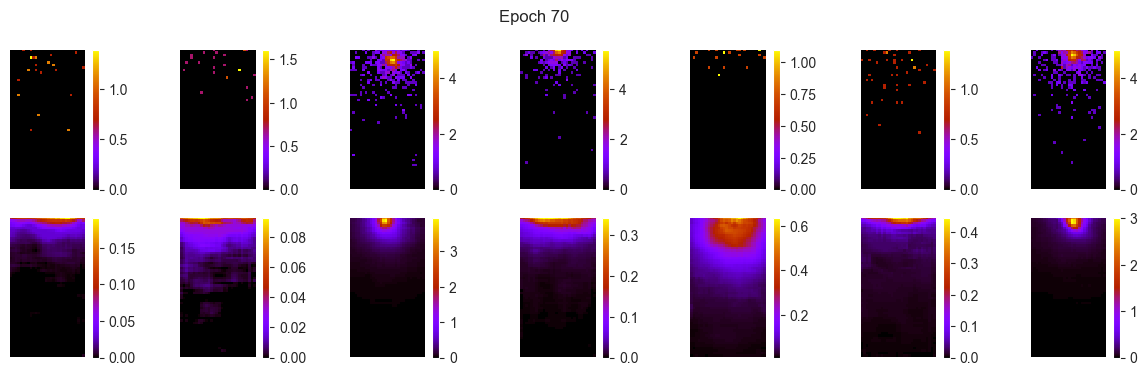

100 [Total loss: 47.17] [Recon_loss: 47.17] [KL loss: 0.00]
200 [Total loss: 49.45] [Recon_loss: 49.45] [KL loss: 0.00]


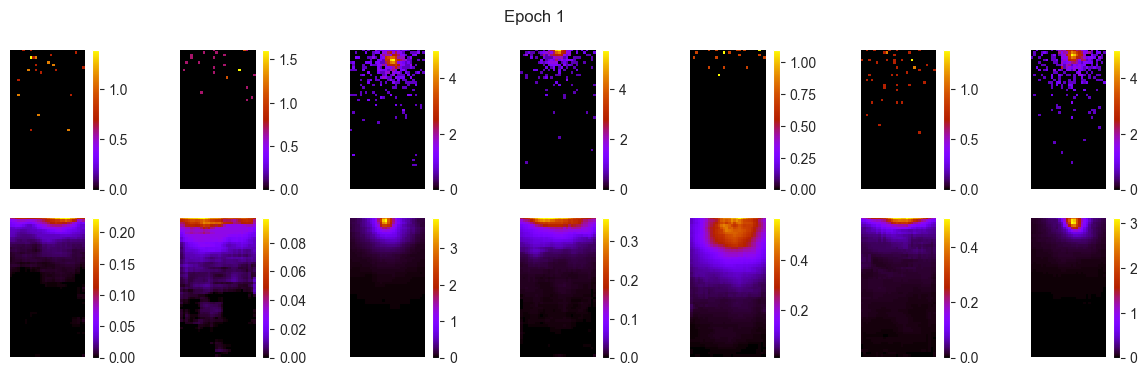

206/206 [==============================] - 2s 8ms/step
ws mean 29.48 ch1 23.57 ch2 48.07 ch3 0.79 ch4 0.78 ch5 74.19 Time for epoch 1 is 22.57405734062195 sec
300 [Total loss: 51.40] [Recon_loss: 51.40] [KL loss: 0.00]
400 [Total loss: 41.68] [Recon_loss: 41.68] [KL loss: 0.00]


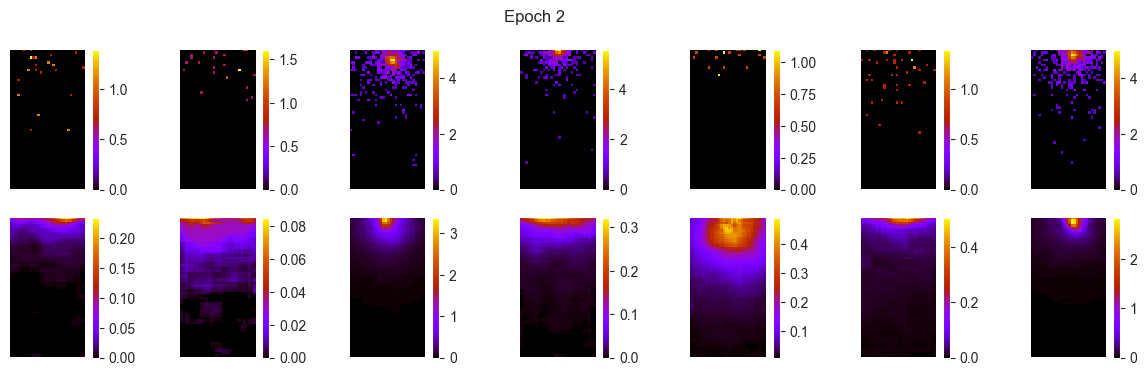

206/206 [==============================] - 2s 8ms/step
ws mean 33.45 ch1 26.02 ch2 55.27 ch3 0.85 ch4 0.84 ch5 84.27 Time for epoch 2 is 19.48251748085022 sec
500 [Total loss: 51.53] [Recon_loss: 51.53] [KL loss: 0.00]
600 [Total loss: 48.66] [Recon_loss: 48.66] [KL loss: 0.00]


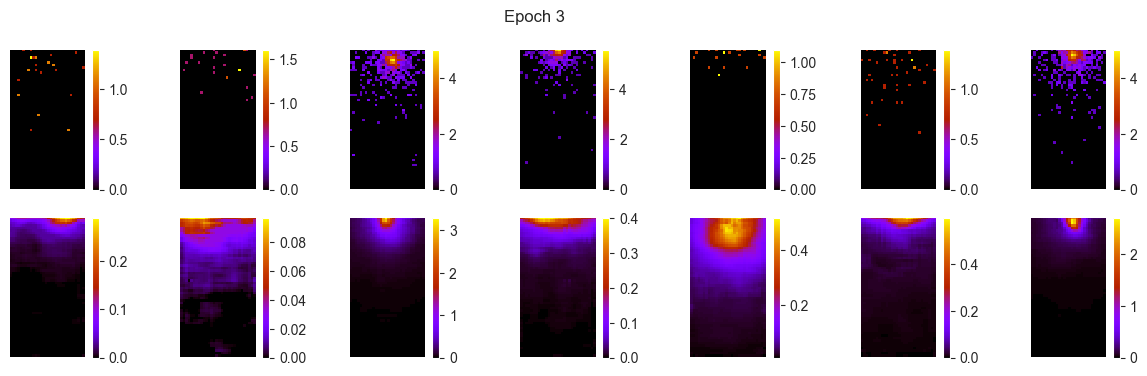

206/206 [==============================] - 2s 8ms/step
ws mean 33.59 ch1 24.89 ch2 56.70 ch3 0.76 ch4 0.76 ch5 84.83 Time for epoch 3 is 19.36226749420166 sec
700 [Total loss: 43.17] [Recon_loss: 43.17] [KL loss: 0.00]
800 [Total loss: 46.66] [Recon_loss: 46.66] [KL loss: 0.00]


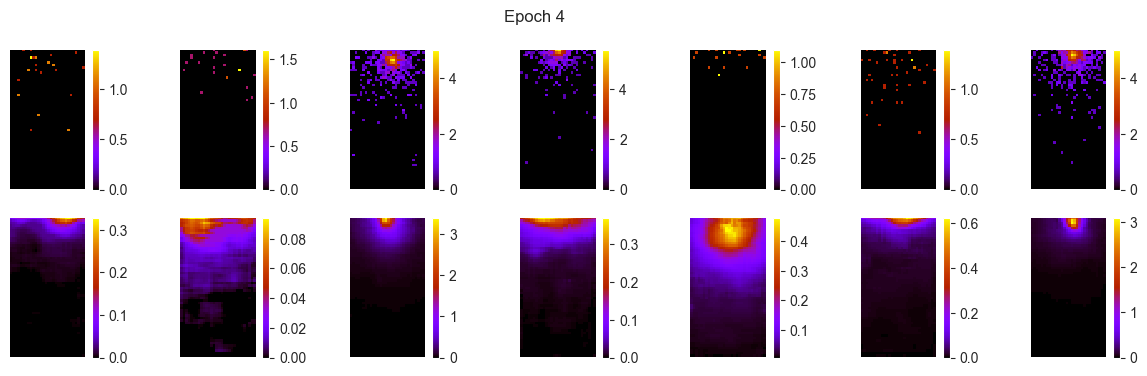

206/206 [==============================] - 2s 8ms/step
ws mean 33.12 ch1 25.18 ch2 55.23 ch3 0.81 ch4 0.82 ch5 83.59 Time for epoch 4 is 19.400714874267578 sec
900 [Total loss: 48.58] [Recon_loss: 48.58] [KL loss: 0.00]
1000 [Total loss: 44.96] [Recon_loss: 44.96] [KL loss: 0.00]


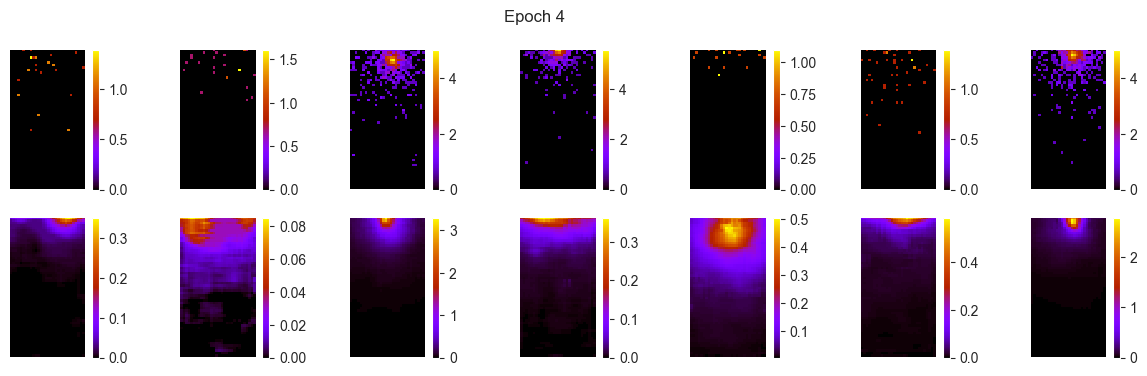

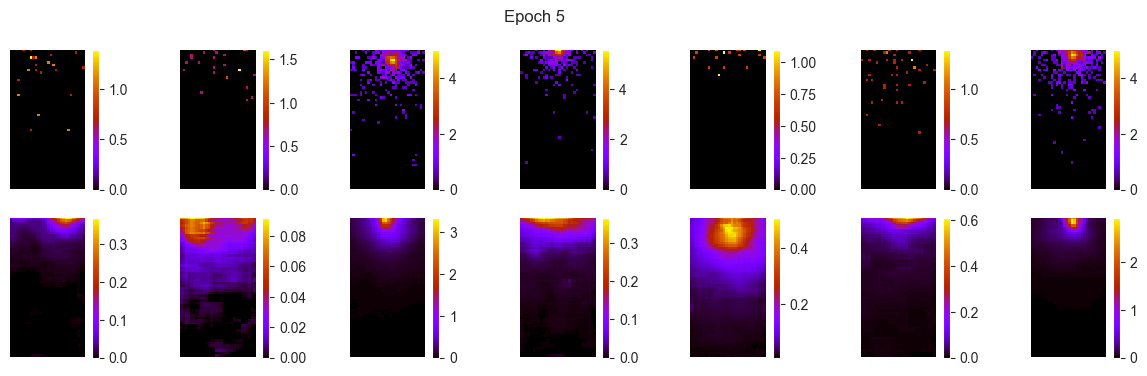

206/206 [==============================] - 2s 8ms/step
ws mean 33.39 ch1 24.68 ch2 56.19 ch3 0.84 ch4 0.82 ch5 84.42 Time for epoch 5 is 23.172533988952637 sec
1100 [Total loss: 49.24] [Recon_loss: 49.24] [KL loss: 0.00]
1200 [Total loss: 50.49] [Recon_loss: 50.49] [KL loss: 0.00]


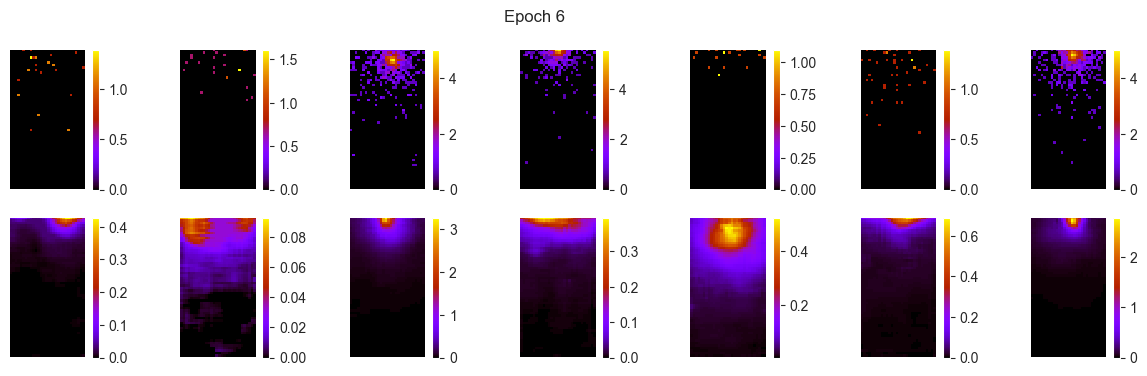

206/206 [==============================] - 1s 7ms/step
ws mean 35.22 ch1 25.43 ch2 59.88 ch3 0.81 ch4 0.85 ch5 89.11 Time for epoch 6 is 21.296981811523438 sec
1300 [Total loss: 45.92] [Recon_loss: 45.92] [KL loss: 0.00]
1400 [Total loss: 49.61] [Recon_loss: 49.61] [KL loss: 0.00]


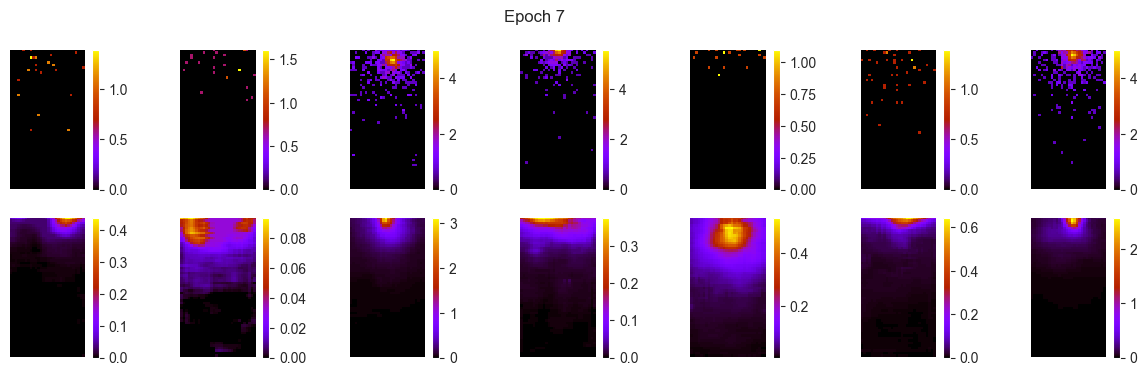

206/206 [==============================] - 1s 7ms/step
ws mean 35.97 ch1 26.29 ch2 60.91 ch3 0.79 ch4 0.85 ch5 91.02 Time for epoch 7 is 21.331890106201172 sec
1500 [Total loss: 48.84] [Recon_loss: 48.84] [KL loss: 0.00]
1600 [Total loss: 46.10] [Recon_loss: 46.10] [KL loss: 0.00]


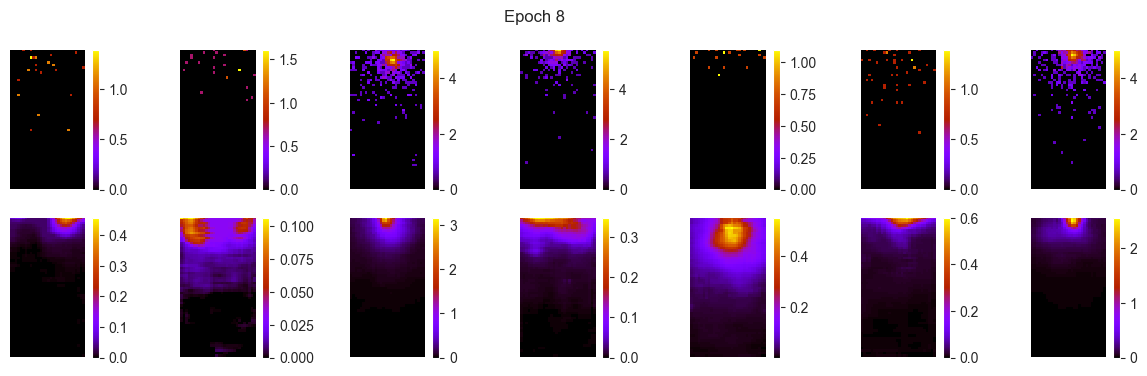

206/206 [==============================] - 1s 7ms/step
ws mean 36.12 ch1 26.35 ch2 61.16 ch3 0.78 ch4 0.80 ch5 91.51 Time for epoch 8 is 21.648067712783813 sec
1700 [Total loss: 49.42] [Recon_loss: 49.42] [KL loss: 0.00]
1800 [Total loss: 48.87] [Recon_loss: 48.87] [KL loss: 0.00]


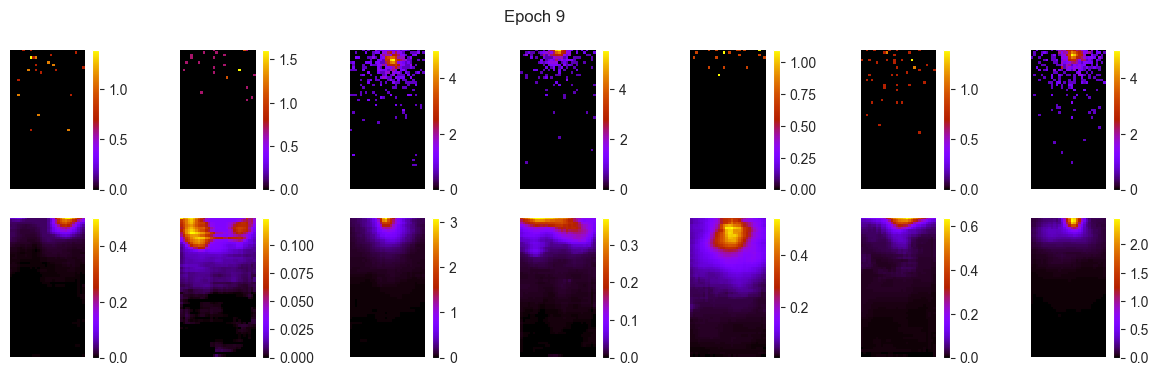

206/206 [==============================] - 1s 7ms/step
ws mean 36.89 ch1 26.98 ch2 62.40 ch3 0.79 ch4 0.81 ch5 93.48 Time for epoch 9 is 21.539886713027954 sec
1900 [Total loss: 46.94] [Recon_loss: 46.94] [KL loss: 0.00]
2000 [Total loss: 45.80] [Recon_loss: 45.80] [KL loss: 0.00]


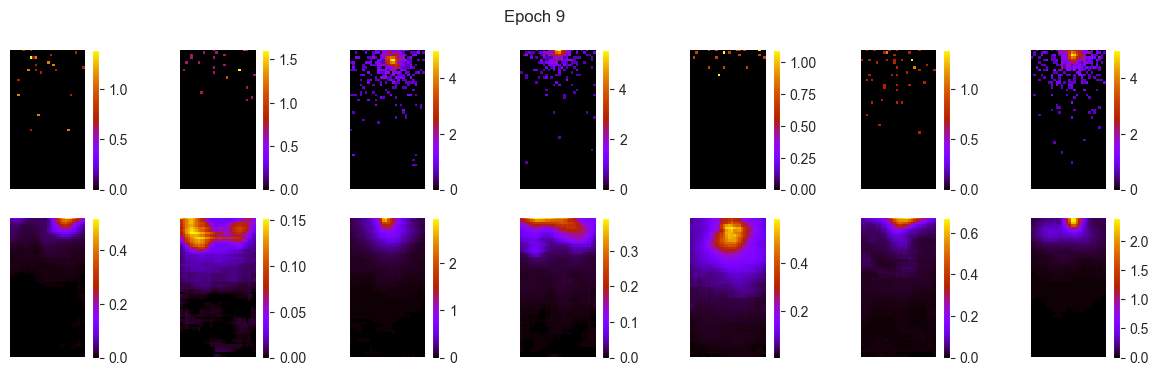

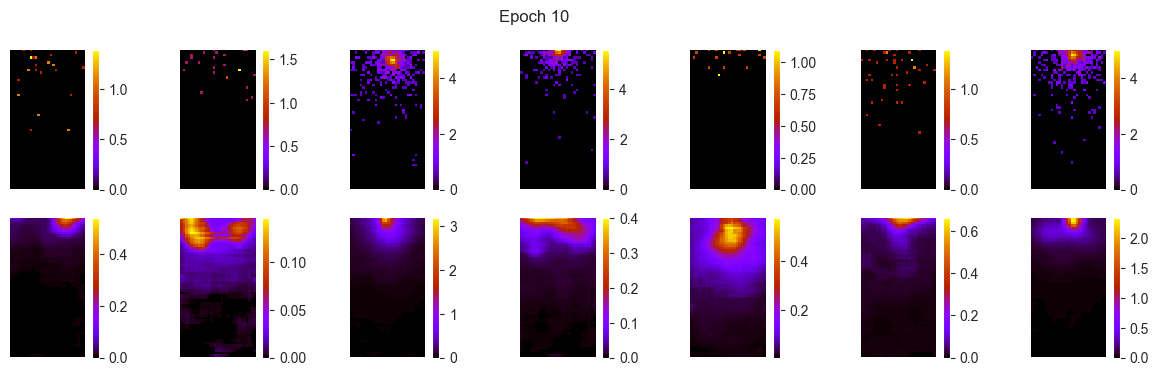

206/206 [==============================] - 1s 7ms/step
ws mean 36.96 ch1 27.18 ch2 62.39 ch3 0.80 ch4 0.83 ch5 93.62 Time for epoch 10 is 25.42309069633484 sec
2100 [Total loss: 51.34] [Recon_loss: 51.34] [KL loss: 0.00]
2200 [Total loss: 46.52] [Recon_loss: 46.52] [KL loss: 0.00]


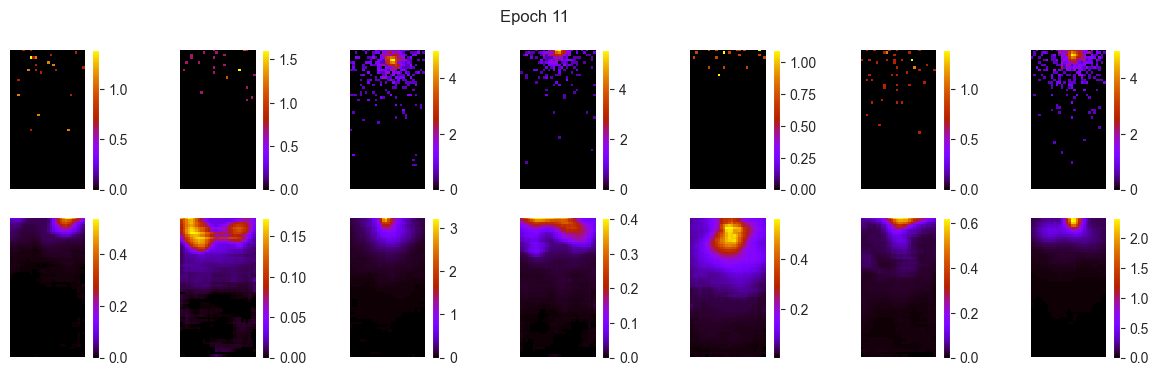

206/206 [==============================] - 1s 7ms/step
ws mean 37.78 ch1 27.78 ch2 63.74 ch3 0.81 ch4 0.81 ch5 95.77 Time for epoch 11 is 23.460198879241943 sec
2300 [Total loss: 44.38] [Recon_loss: 44.38] [KL loss: 0.00]
2400 [Total loss: 48.09] [Recon_loss: 48.09] [KL loss: 0.00]


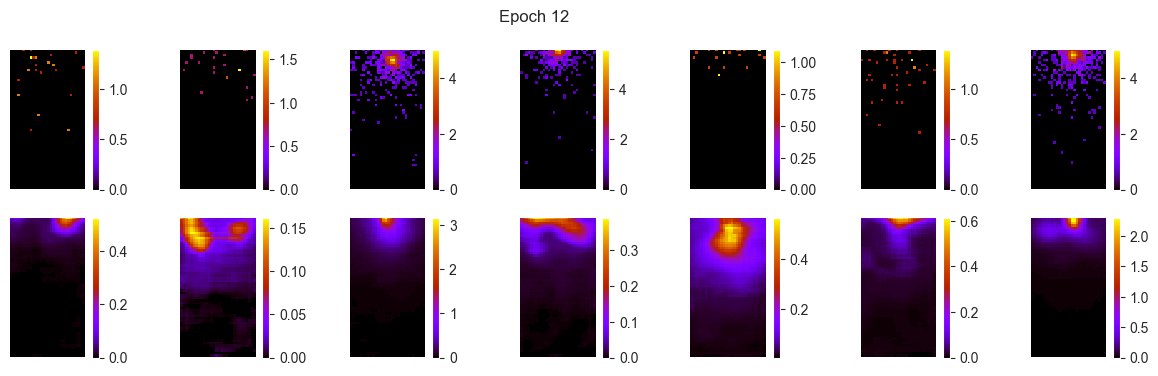

206/206 [==============================] - 1s 7ms/step
ws mean 37.53 ch1 27.47 ch2 63.39 ch3 0.78 ch4 0.79 ch5 95.22 Time for epoch 12 is 23.09930944442749 sec
2500 [Total loss: 38.71] [Recon_loss: 38.71] [KL loss: 0.00]
2600 [Total loss: 44.08] [Recon_loss: 44.08] [KL loss: 0.00]


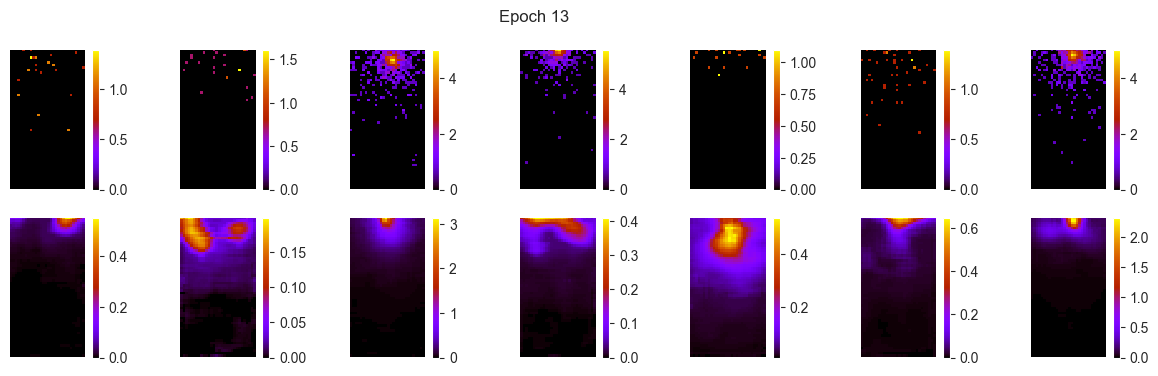

206/206 [==============================] - 1s 7ms/step
ws mean 38.67 ch1 28.61 ch2 65.08 ch3 0.78 ch4 0.76 ch5 98.13 Time for epoch 13 is 23.70474100112915 sec
2700 [Total loss: 40.62] [Recon_loss: 40.62] [KL loss: 0.00]
2800 [Total loss: 47.25] [Recon_loss: 47.25] [KL loss: 0.00]


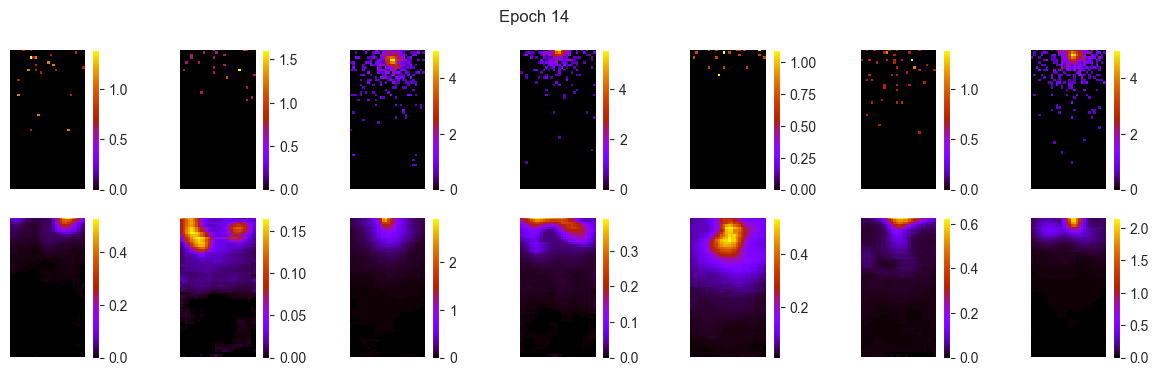

206/206 [==============================] - 1s 7ms/step
ws mean 39.82 ch1 28.98 ch2 67.48 ch3 0.71 ch4 0.75 ch5 101.15 Time for epoch 14 is 23.18531560897827 sec
2900 [Total loss: 44.71] [Recon_loss: 44.71] [KL loss: 0.00]
3000 [Total loss: 47.30] [Recon_loss: 47.30] [KL loss: 0.00]


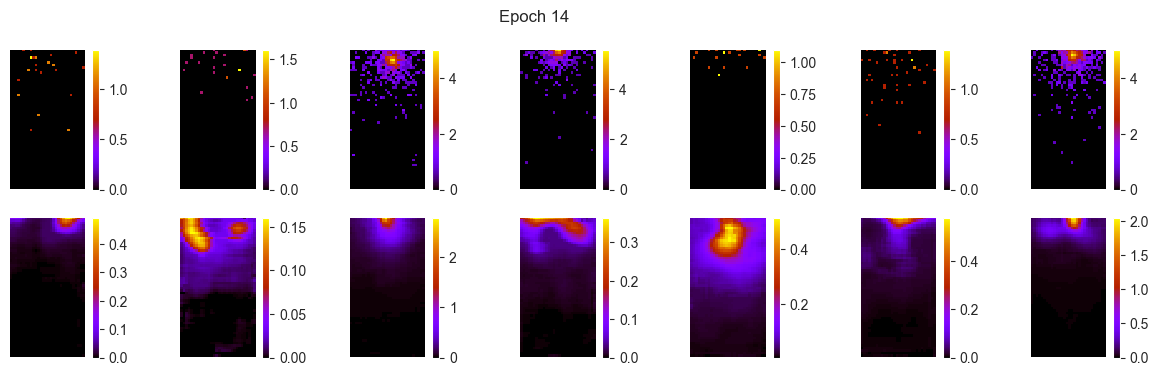

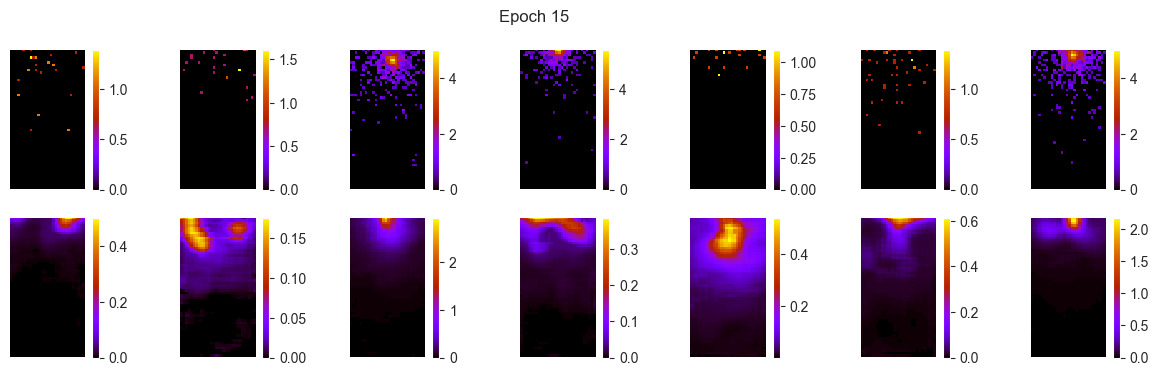

206/206 [==============================] - 1s 7ms/step
ws mean 39.08 ch1 28.51 ch2 66.21 ch3 0.71 ch4 0.76 ch5 99.19 Time for epoch 15 is 27.381291389465332 sec
3100 [Total loss: 35.88] [Recon_loss: 35.88] [KL loss: 0.00]
3200 [Total loss: 39.02] [Recon_loss: 39.02] [KL loss: 0.00]


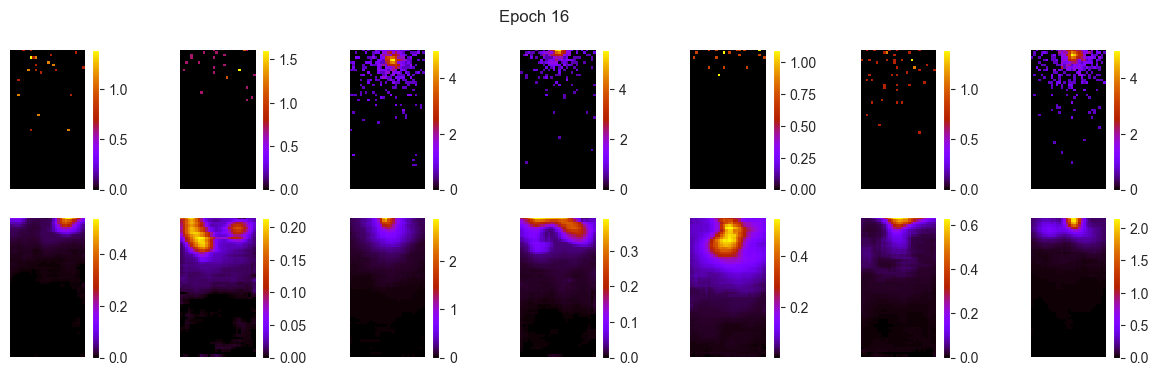

206/206 [==============================] - 1s 7ms/step
ws mean 40.01 ch1 29.60 ch2 67.25 ch3 0.77 ch4 0.78 ch5 101.64 Time for epoch 16 is 25.960748434066772 sec
3300 [Total loss: 45.66] [Recon_loss: 45.66] [KL loss: 0.00]
3400 [Total loss: 49.57] [Recon_loss: 49.57] [KL loss: 0.00]
3500 [Total loss: 46.00] [Recon_loss: 46.00] [KL loss: 0.00]


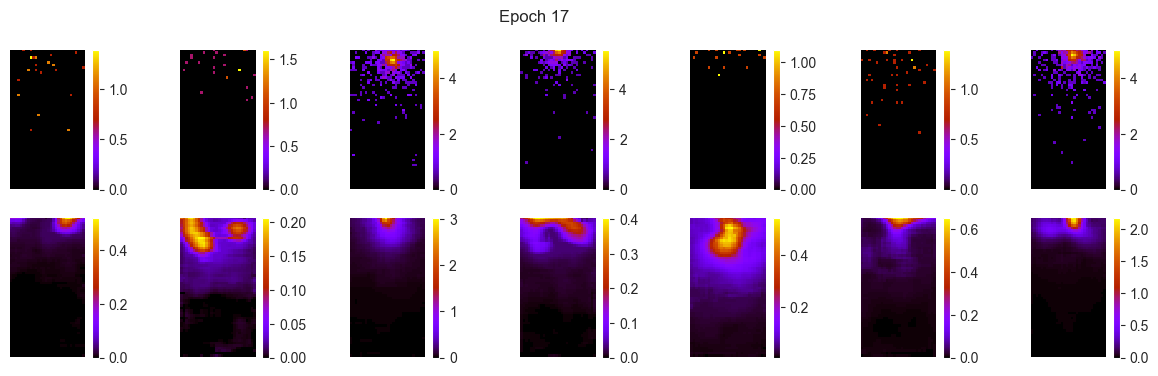

206/206 [==============================] - 1s 7ms/step
ws mean 40.40 ch1 29.90 ch2 67.91 ch3 0.77 ch4 0.81 ch5 102.61 Time for epoch 17 is 25.200336456298828 sec
3600 [Total loss: 38.51] [Recon_loss: 38.51] [KL loss: 0.00]
3700 [Total loss: 46.50] [Recon_loss: 46.50] [KL loss: 0.00]


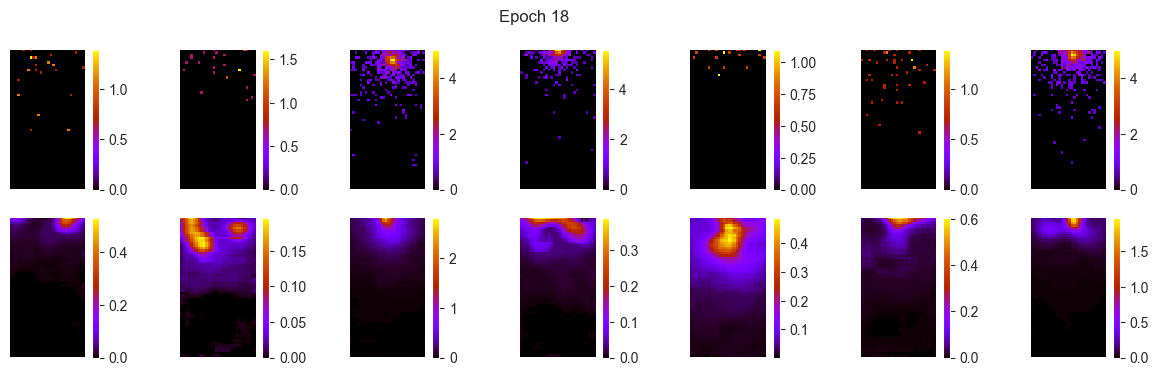

206/206 [==============================] - 1s 7ms/step
ws mean 42.11 ch1 30.84 ch2 71.20 ch3 0.71 ch4 0.74 ch5 107.05 Time for epoch 18 is 26.128928899765015 sec
3800 [Total loss: 44.61] [Recon_loss: 44.61] [KL loss: 0.00]
3900 [Total loss: 47.32] [Recon_loss: 47.32] [KL loss: 0.00]


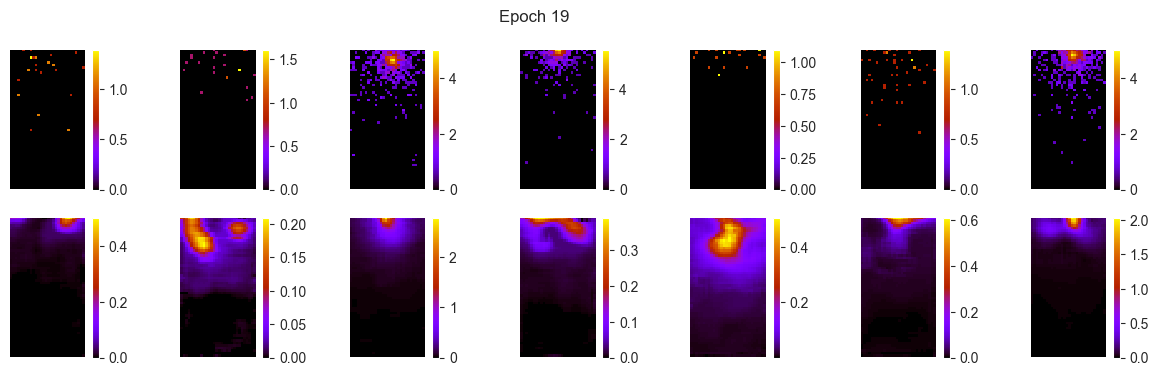

206/206 [==============================] - 1s 7ms/step
ws mean 41.73 ch1 30.69 ch2 70.44 ch3 0.67 ch4 0.68 ch5 106.19 Time for epoch 19 is 25.57245922088623 sec
4000 [Total loss: 46.15] [Recon_loss: 46.15] [KL loss: 0.00]


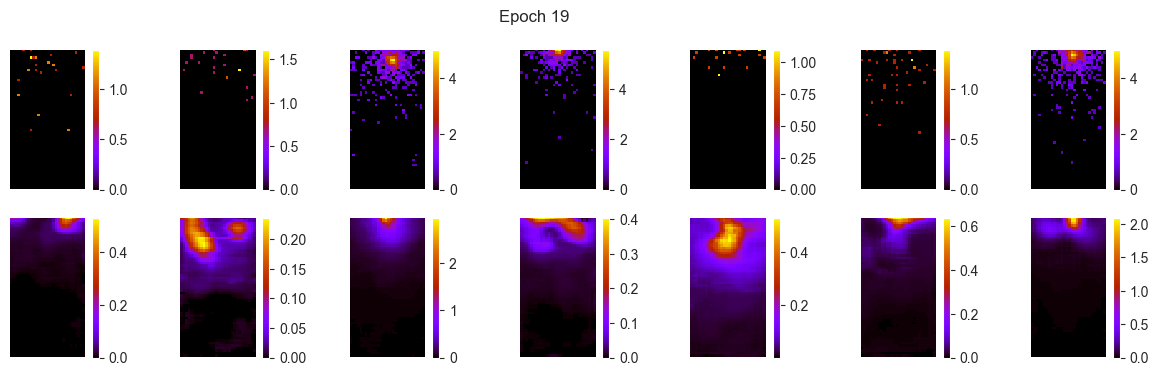

4100 [Total loss: 45.77] [Recon_loss: 45.77] [KL loss: 0.00]


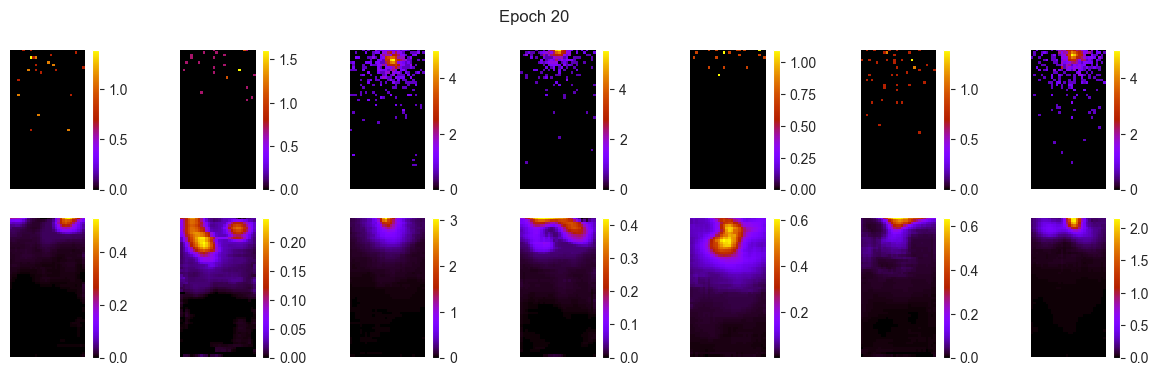

206/206 [==============================] - 1s 7ms/step
ws mean 40.41 ch1 30.31 ch2 67.50 ch3 0.73 ch4 0.76 ch5 102.76 Time for epoch 20 is 29.00526738166809 sec
4200 [Total loss: 48.94] [Recon_loss: 48.94] [KL loss: 0.00]
4300 [Total loss: 48.32] [Recon_loss: 48.32] [KL loss: 0.00]


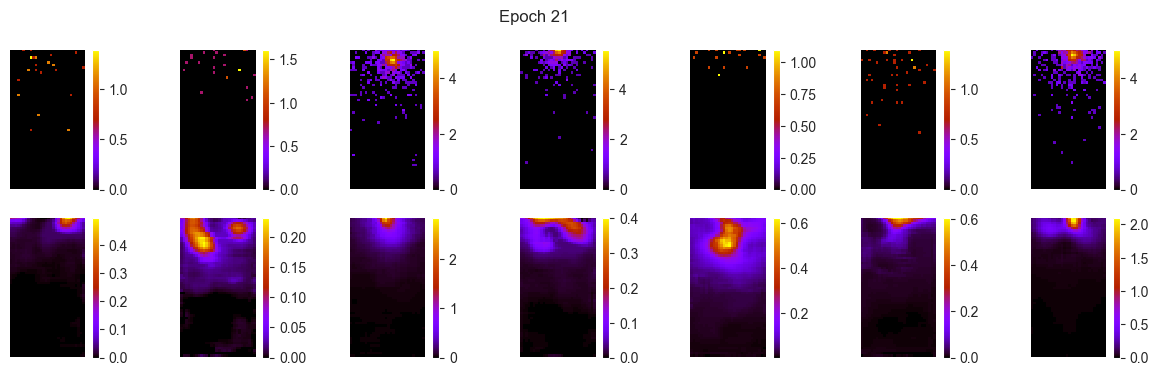

206/206 [==============================] - 1s 7ms/step
ws mean 41.13 ch1 30.62 ch2 68.99 ch3 0.67 ch4 0.73 ch5 104.64 Time for epoch 21 is 27.78458023071289 sec
4400 [Total loss: 48.51] [Recon_loss: 48.51] [KL loss: 0.00]
4500 [Total loss: 46.07] [Recon_loss: 46.07] [KL loss: 0.00]


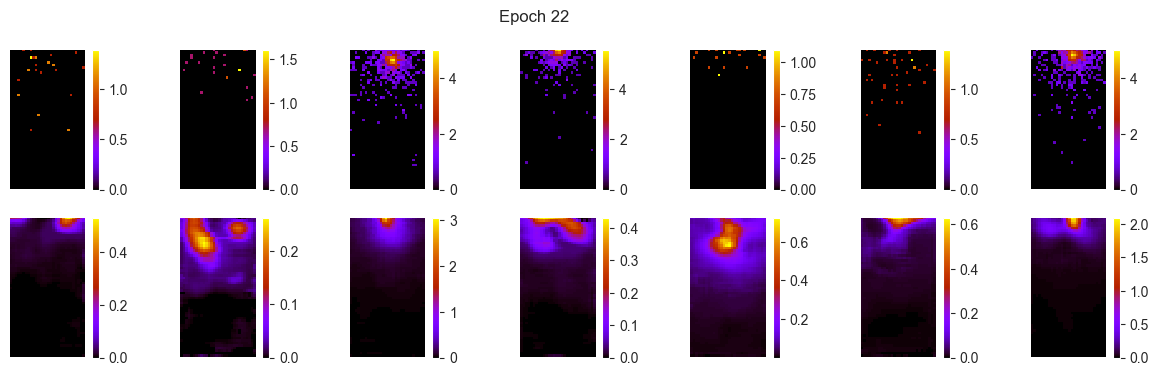

206/206 [==============================] - 1s 7ms/step
ws mean 41.03 ch1 30.71 ch2 68.57 ch3 0.71 ch4 0.75 ch5 104.43 Time for epoch 22 is 27.203023672103882 sec
4600 [Total loss: 48.07] [Recon_loss: 48.07] [KL loss: 0.00]
4700 [Total loss: 46.28] [Recon_loss: 46.28] [KL loss: 0.00]


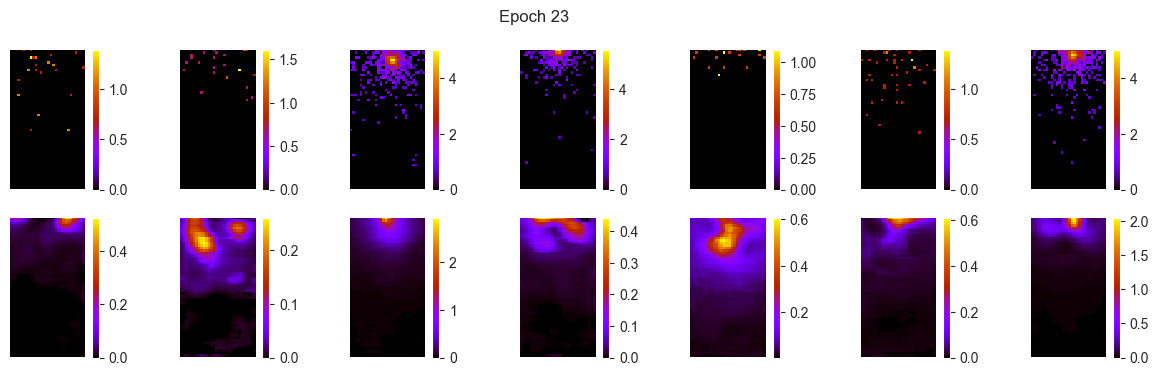

206/206 [==============================] - 1s 7ms/step
ws mean 41.75 ch1 31.11 ch2 69.91 ch3 0.75 ch4 0.78 ch5 106.19 Time for epoch 23 is 27.43822956085205 sec
4800 [Total loss: 42.64] [Recon_loss: 42.64] [KL loss: 0.00]
4900 [Total loss: 48.74] [Recon_loss: 48.74] [KL loss: 0.00]


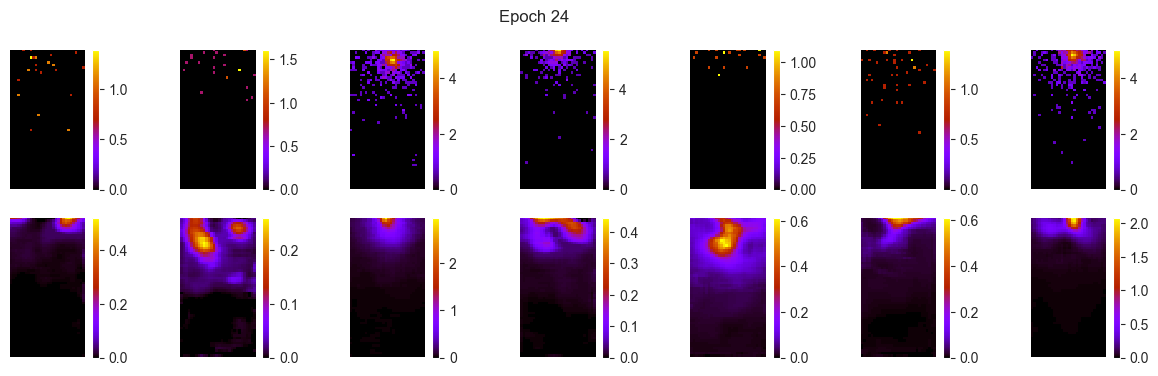

206/206 [==============================] - 1s 7ms/step
ws mean 41.40 ch1 30.95 ch2 69.27 ch3 0.63 ch4 0.65 ch5 105.48 Time for epoch 24 is 27.657088041305542 sec
5000 [Total loss: 41.56] [Recon_loss: 41.56] [KL loss: 0.00]


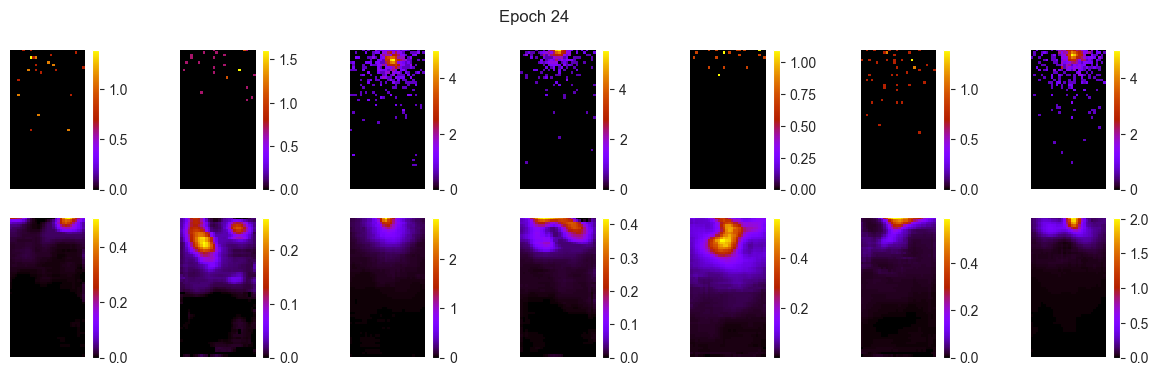

5100 [Total loss: 47.59] [Recon_loss: 47.59] [KL loss: 0.00]


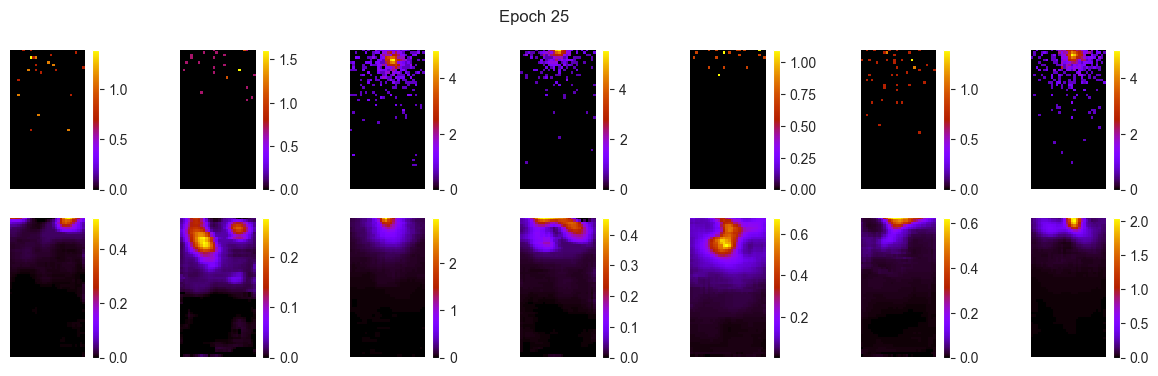

206/206 [==============================] - 1s 7ms/step
ws mean 41.46 ch1 31.06 ch2 69.21 ch3 0.69 ch4 0.73 ch5 105.64 Time for epoch 25 is 31.04487919807434 sec
5200 [Total loss: 52.03] [Recon_loss: 52.03] [KL loss: 0.00]
5300 [Total loss: 46.02] [Recon_loss: 46.02] [KL loss: 0.00]


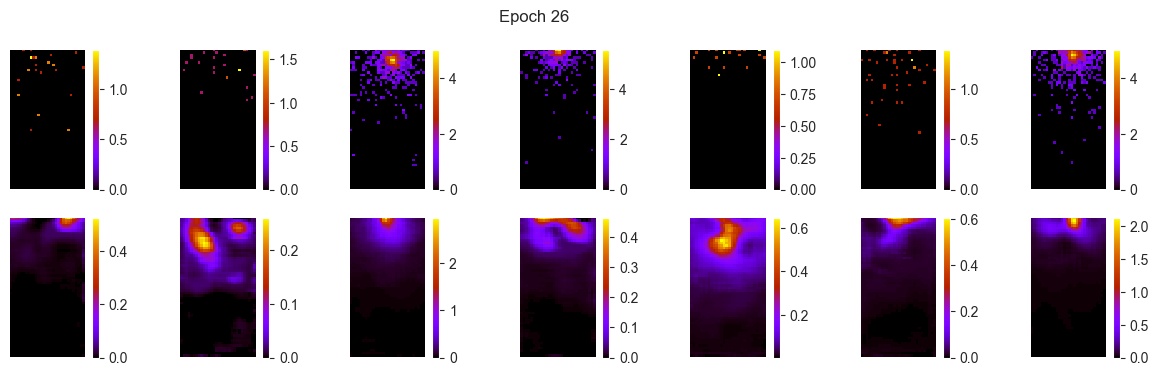

206/206 [==============================] - 1s 7ms/step
ws mean 40.97 ch1 30.59 ch2 68.60 ch3 0.60 ch4 0.60 ch5 104.47 Time for epoch 26 is 27.779802083969116 sec
5400 [Total loss: 40.91] [Recon_loss: 40.91] [KL loss: 0.00]
5500 [Total loss: 39.76] [Recon_loss: 39.76] [KL loss: 0.00]


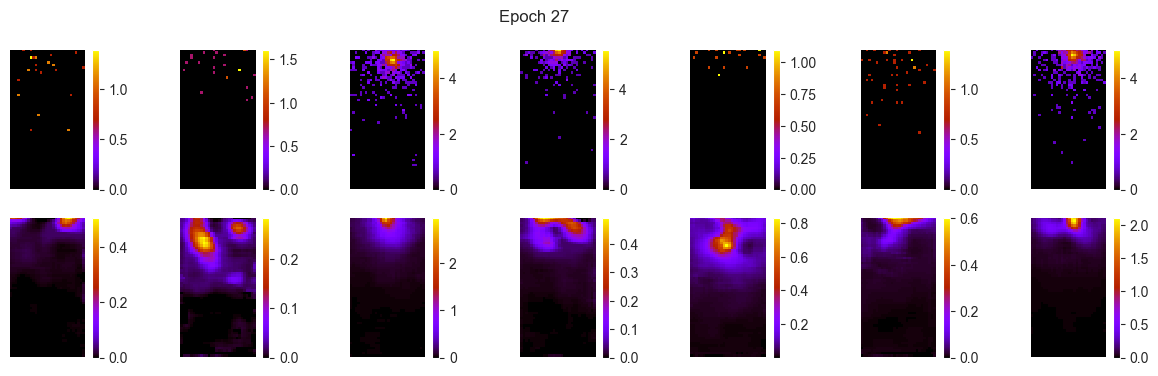

206/206 [==============================] - 1s 7ms/step
ws mean 41.51 ch1 31.20 ch2 69.21 ch3 0.65 ch4 0.69 ch5 105.81 Time for epoch 27 is 27.58703589439392 sec
5600 [Total loss: 46.84] [Recon_loss: 46.84] [KL loss: 0.00]
5700 [Total loss: 47.85] [Recon_loss: 47.85] [KL loss: 0.00]


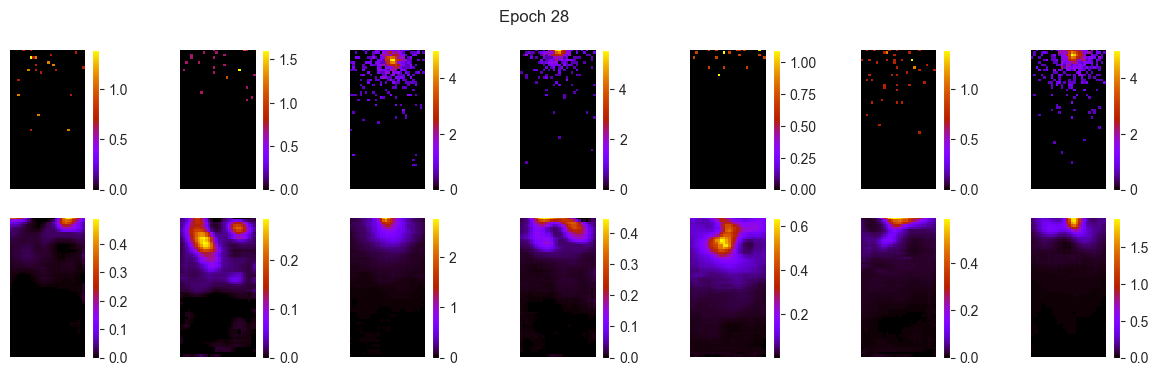

206/206 [==============================] - 1s 7ms/step
ws mean 42.76 ch1 31.61 ch2 71.87 ch3 0.61 ch4 0.60 ch5 109.10 Time for epoch 28 is 27.56718635559082 sec
5800 [Total loss: 39.86] [Recon_loss: 39.86] [KL loss: 0.00]
5900 [Total loss: 47.00] [Recon_loss: 47.00] [KL loss: 0.00]


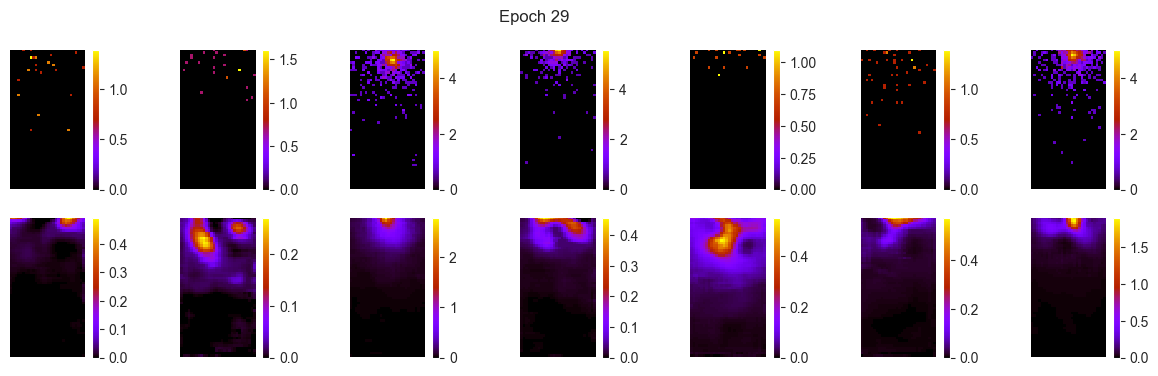

206/206 [==============================] - 1s 7ms/step
ws mean 42.76 ch1 31.34 ch2 72.10 ch3 0.61 ch4 0.59 ch5 109.15 Time for epoch 29 is 28.077542304992676 sec
6000 [Total loss: 44.81] [Recon_loss: 44.81] [KL loss: 0.00]


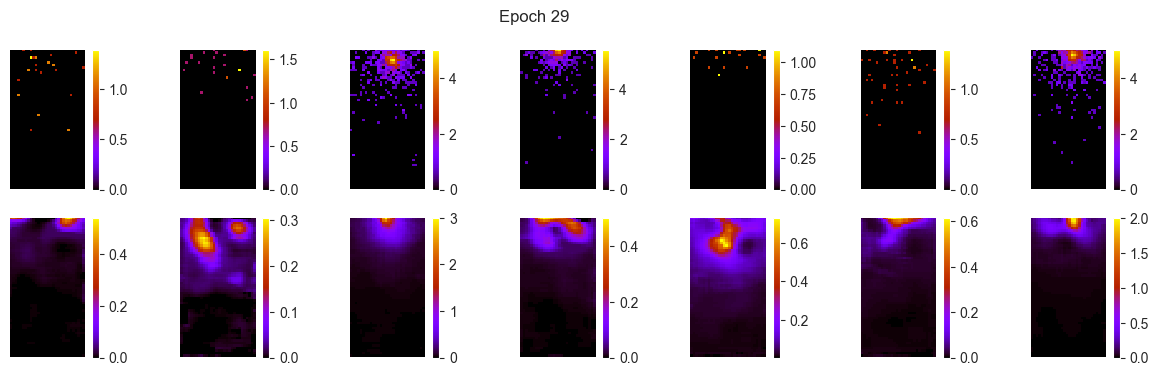

6100 [Total loss: 34.28] [Recon_loss: 34.28] [KL loss: 0.00]


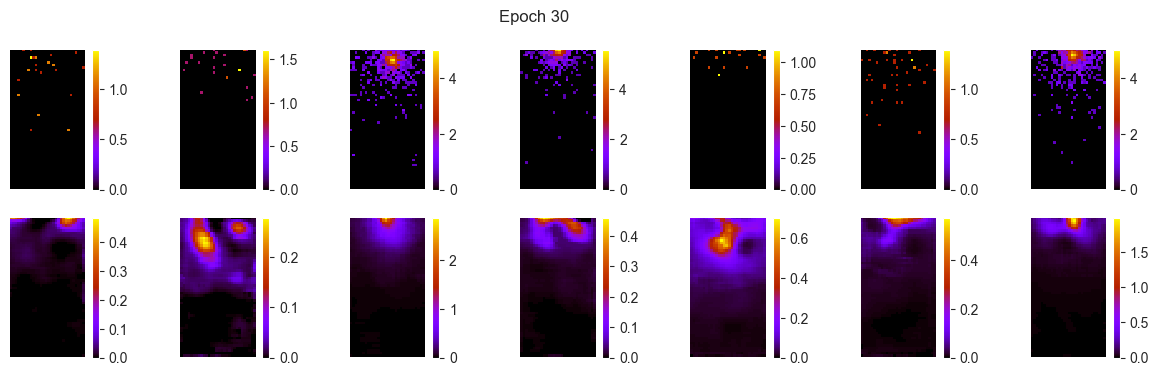

206/206 [==============================] - 1s 7ms/step
ws mean 42.08 ch1 30.92 ch2 70.92 ch3 0.58 ch4 0.57 ch5 107.41 Time for epoch 30 is 31.375412940979004 sec
6200 [Total loss: 38.29] [Recon_loss: 38.29] [KL loss: 0.00]
6300 [Total loss: 48.35] [Recon_loss: 48.35] [KL loss: 0.00]


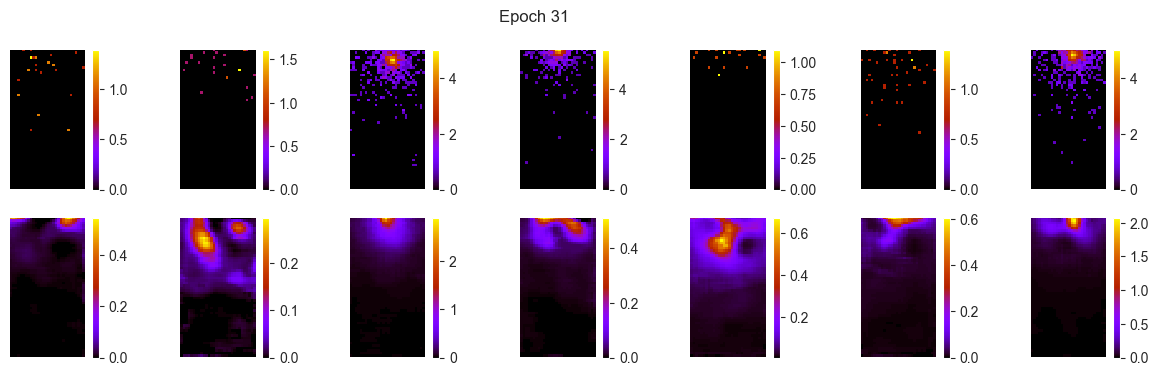

206/206 [==============================] - 1s 7ms/step
ws mean 42.28 ch1 31.27 ch2 70.80 ch3 0.60 ch4 0.69 ch5 108.04 Time for epoch 31 is 27.868820667266846 sec
6400 [Total loss: 45.59] [Recon_loss: 45.59] [KL loss: 0.00]
6500 [Total loss: 43.01] [Recon_loss: 43.01] [KL loss: 0.00]


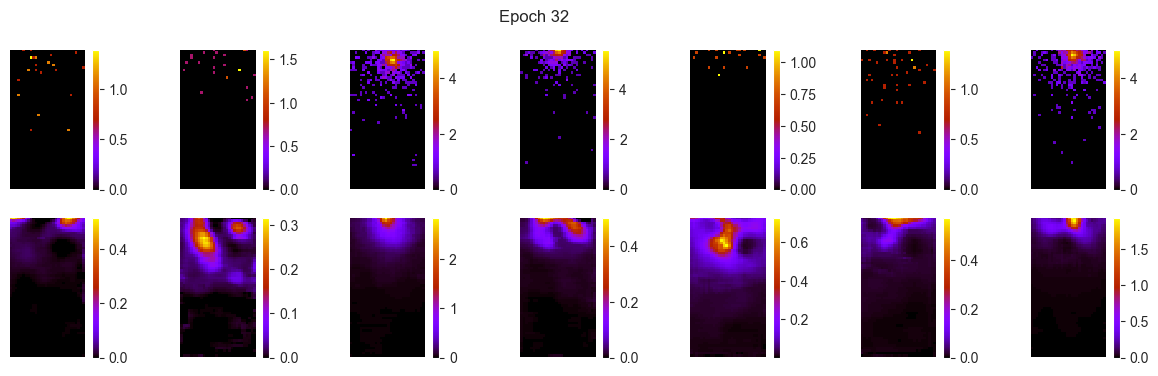

206/206 [==============================] - 1s 7ms/step
ws mean 42.69 ch1 31.61 ch2 71.57 ch3 0.61 ch4 0.61 ch5 109.08 Time for epoch 32 is 28.15592646598816 sec
6600 [Total loss: 43.12] [Recon_loss: 43.12] [KL loss: 0.00]
6700 [Total loss: 47.46] [Recon_loss: 47.46] [KL loss: 0.00]


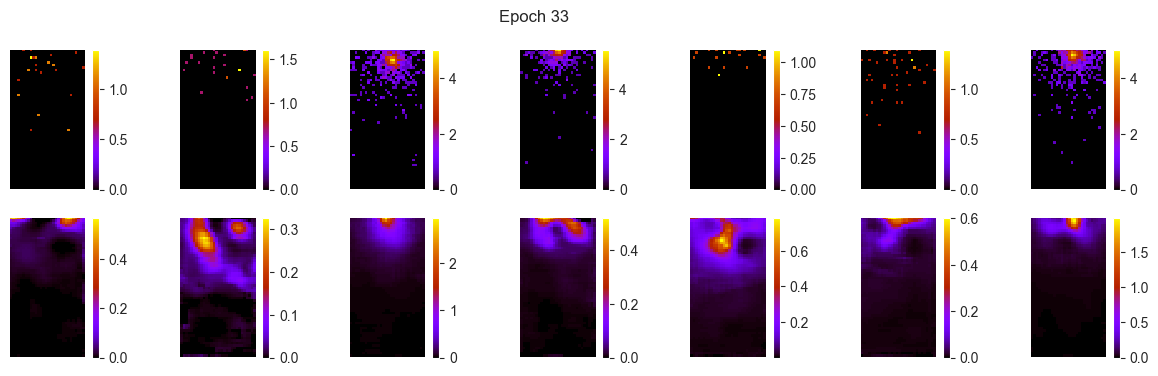

206/206 [==============================] - 1s 7ms/step
ws mean 42.70 ch1 31.66 ch2 71.16 ch3 0.76 ch4 0.94 ch5 108.96 Time for epoch 33 is 27.81247115135193 sec
6800 [Total loss: 49.32] [Recon_loss: 49.32] [KL loss: 0.00]
6900 [Total loss: 34.15] [Recon_loss: 34.15] [KL loss: 0.00]
7000 [Total loss: 48.34] [Recon_loss: 48.34] [KL loss: 0.00]


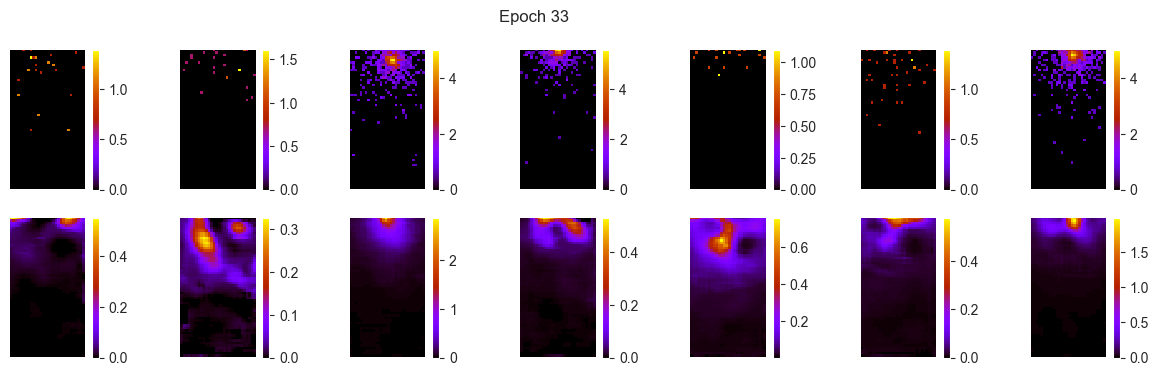

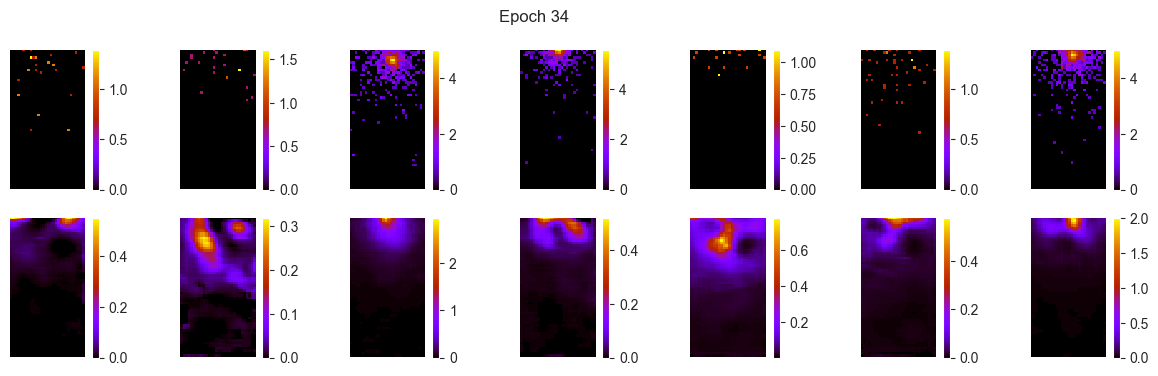

206/206 [==============================] - 1s 7ms/step
ws mean 42.79 ch1 31.59 ch2 71.53 ch3 0.62 ch4 0.80 ch5 109.40 Time for epoch 34 is 34.36278176307678 sec
7100 [Total loss: 43.49] [Recon_loss: 43.49] [KL loss: 0.00]
7200 [Total loss: 38.03] [Recon_loss: 38.03] [KL loss: 0.00]


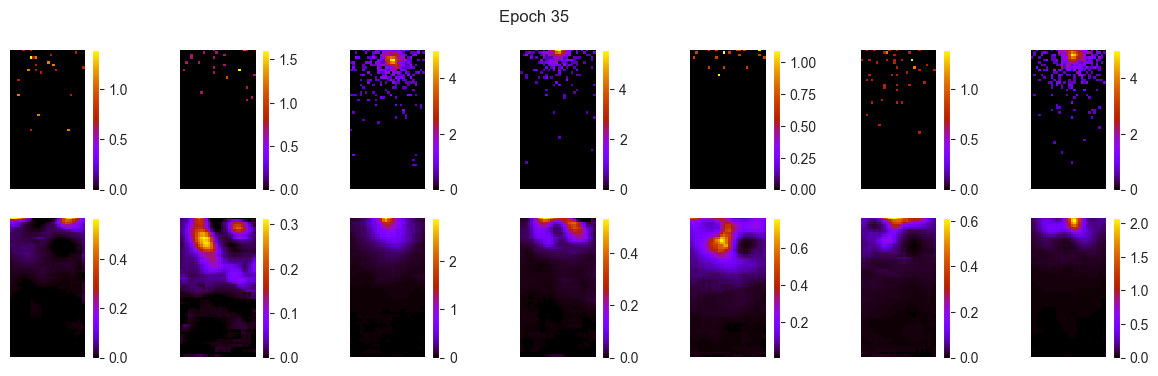

206/206 [==============================] - 1s 7ms/step
ws mean 42.82 ch1 31.50 ch2 71.58 ch3 0.69 ch4 0.87 ch5 109.46 Time for epoch 35 is 28.46777033805847 sec
7300 [Total loss: 47.55] [Recon_loss: 47.55] [KL loss: 0.00]
7400 [Total loss: 37.95] [Recon_loss: 37.95] [KL loss: 0.00]


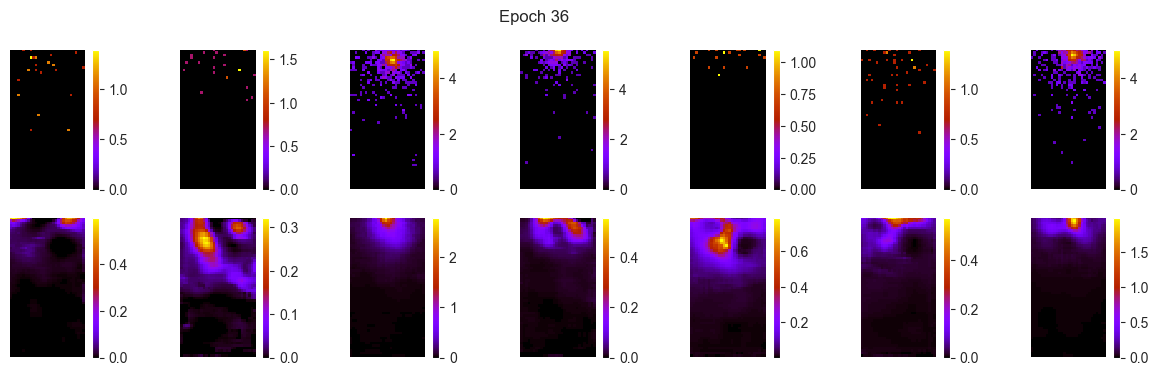

206/206 [==============================] - 1s 7ms/step
ws mean 43.54 ch1 31.79 ch2 72.88 ch3 0.73 ch4 0.95 ch5 111.35 Time for epoch 36 is 27.425528049468994 sec
7500 [Total loss: 44.96] [Recon_loss: 44.96] [KL loss: 0.00]
7600 [Total loss: 44.95] [Recon_loss: 44.95] [KL loss: 0.00]


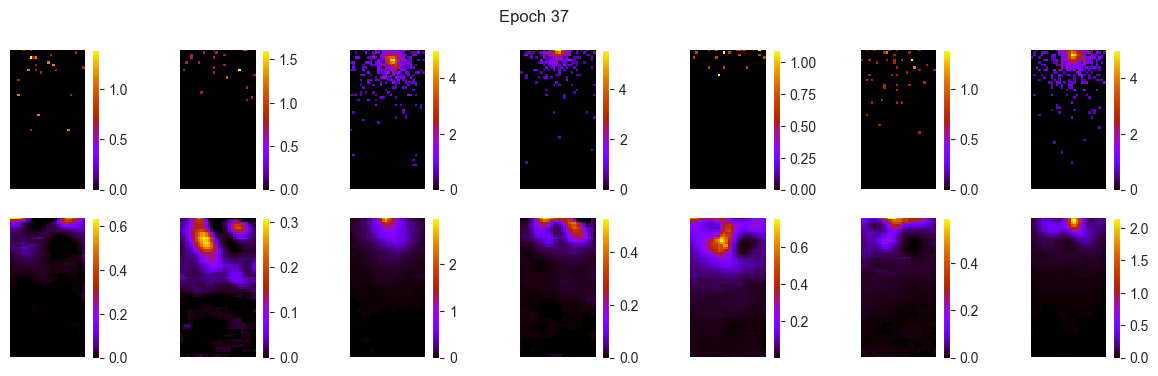

206/206 [==============================] - 1s 7ms/step
ws mean 42.90 ch1 31.25 ch2 71.93 ch3 0.54 ch4 0.67 ch5 110.12 Time for epoch 37 is 28.12322187423706 sec
7700 [Total loss: 46.84] [Recon_loss: 46.84] [KL loss: 0.00]
7800 [Total loss: 42.37] [Recon_loss: 42.37] [KL loss: 0.00]


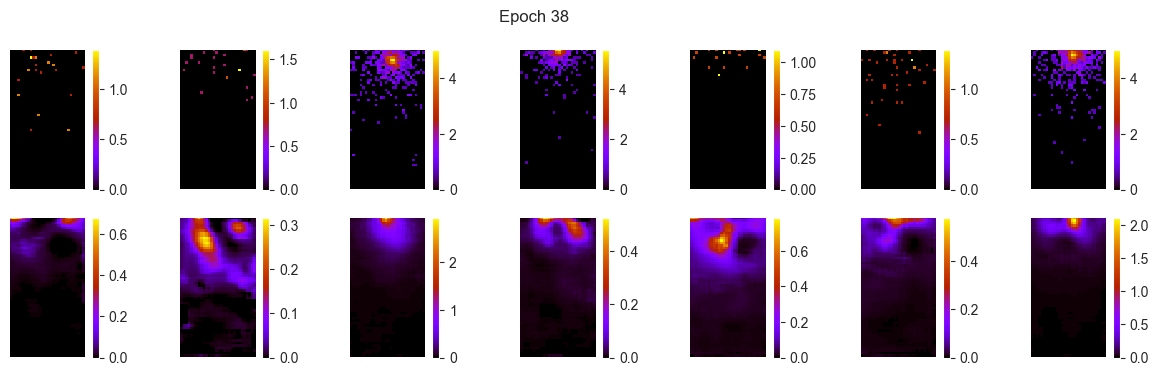

206/206 [==============================] - 1s 7ms/step
ws mean 43.43 ch1 31.56 ch2 72.60 ch3 0.70 ch4 0.90 ch5 111.38 Time for epoch 38 is 26.926396369934082 sec
7900 [Total loss: 48.37] [Recon_loss: 48.37] [KL loss: 0.00]
8000 [Total loss: 45.77] [Recon_loss: 45.77] [KL loss: 0.00]


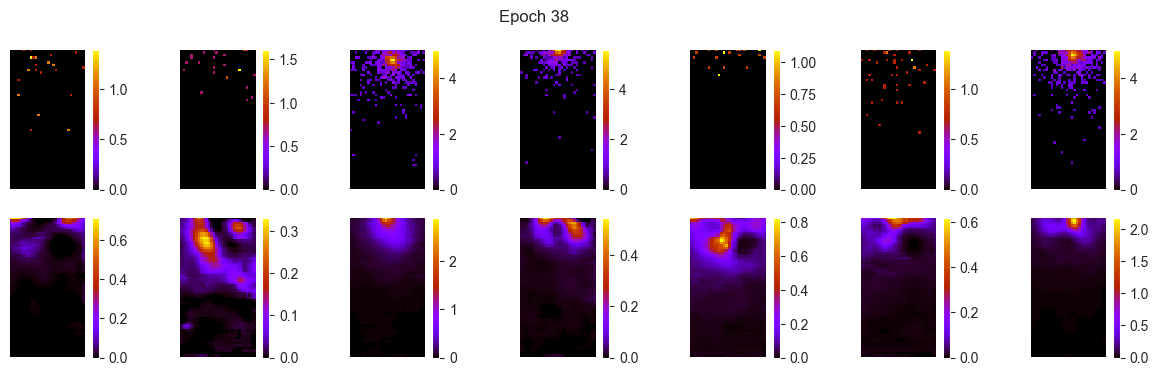

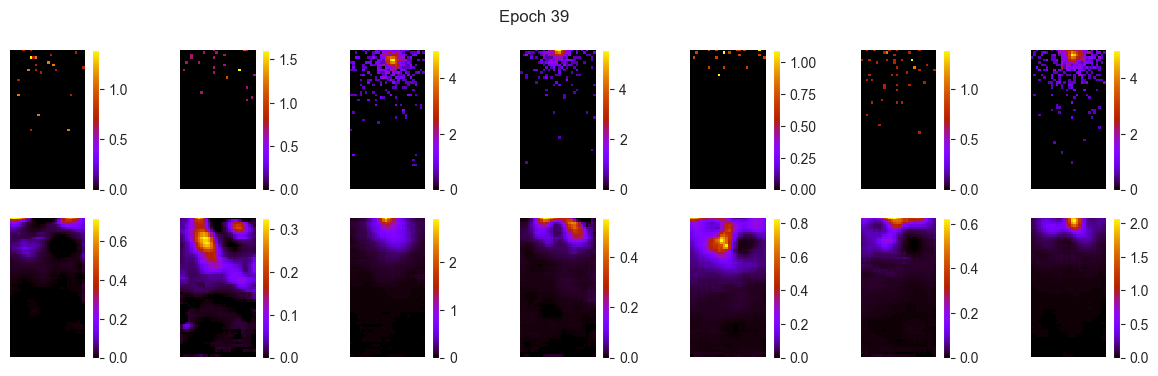

206/206 [==============================] - 1s 7ms/step
ws mean 43.41 ch1 31.36 ch2 72.45 ch3 0.85 ch4 1.07 ch5 111.29 Time for epoch 39 is 32.906397581100464 sec
8100 [Total loss: 49.01] [Recon_loss: 49.01] [KL loss: 0.00]
8200 [Total loss: 38.73] [Recon_loss: 38.73] [KL loss: 0.00]


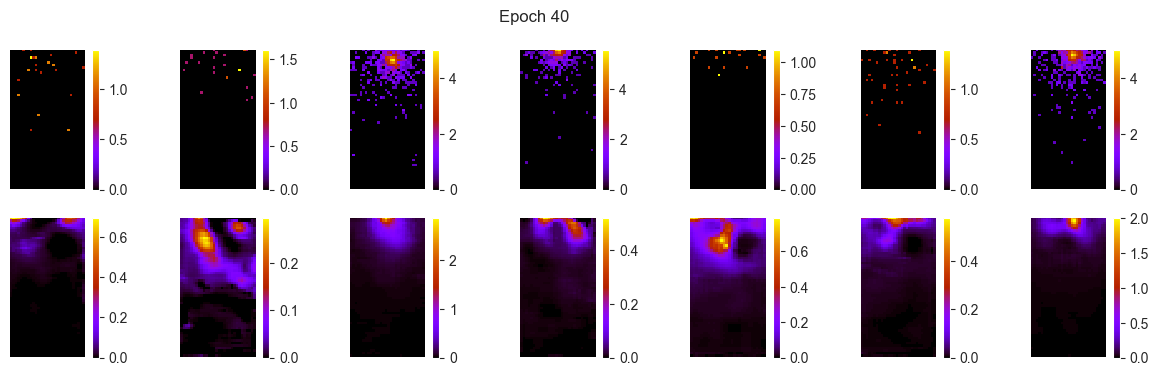

206/206 [==============================] - 1s 7ms/step
ws mean 44.01 ch1 31.37 ch2 74.30 ch3 0.57 ch4 0.68 ch5 113.14 Time for epoch 40 is 28.379817008972168 sec
8300 [Total loss: 36.14] [Recon_loss: 36.14] [KL loss: 0.00]
8400 [Total loss: 42.45] [Recon_loss: 42.45] [KL loss: 0.00]


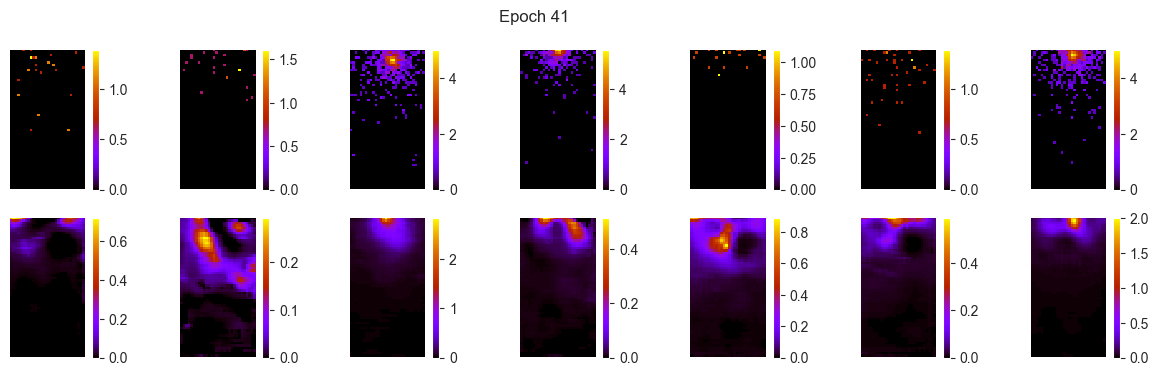

206/206 [==============================] - 1s 7ms/step
ws mean 43.89 ch1 31.14 ch2 74.08 ch3 0.53 ch4 0.76 ch5 112.95 Time for epoch 41 is 28.236300230026245 sec
8500 [Total loss: 38.64] [Recon_loss: 38.64] [KL loss: 0.00]
8600 [Total loss: 37.45] [Recon_loss: 37.45] [KL loss: 0.00]


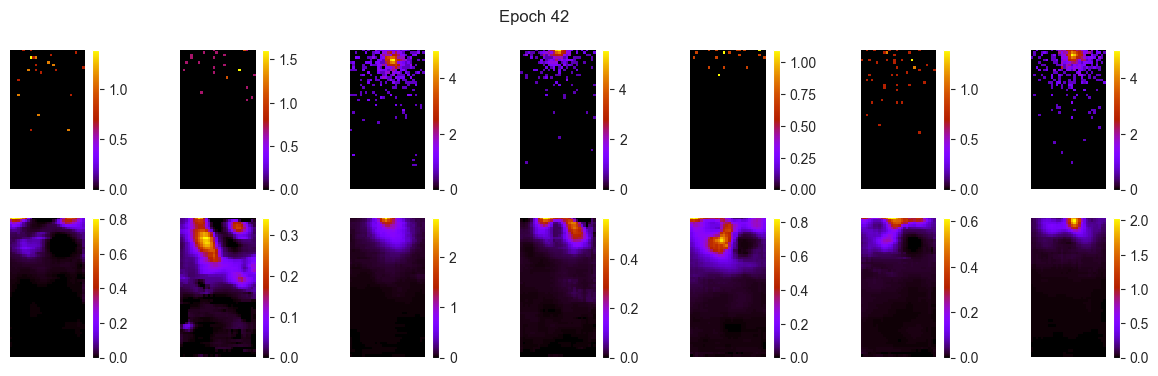

206/206 [==============================] - 1s 7ms/step
ws mean 44.87 ch1 31.89 ch2 74.94 ch3 1.06 ch4 1.24 ch5 115.23 Time for epoch 42 is 27.932706594467163 sec
8700 [Total loss: 47.54] [Recon_loss: 47.54] [KL loss: 0.00]
8800 [Total loss: 48.33] [Recon_loss: 48.33] [KL loss: 0.00]


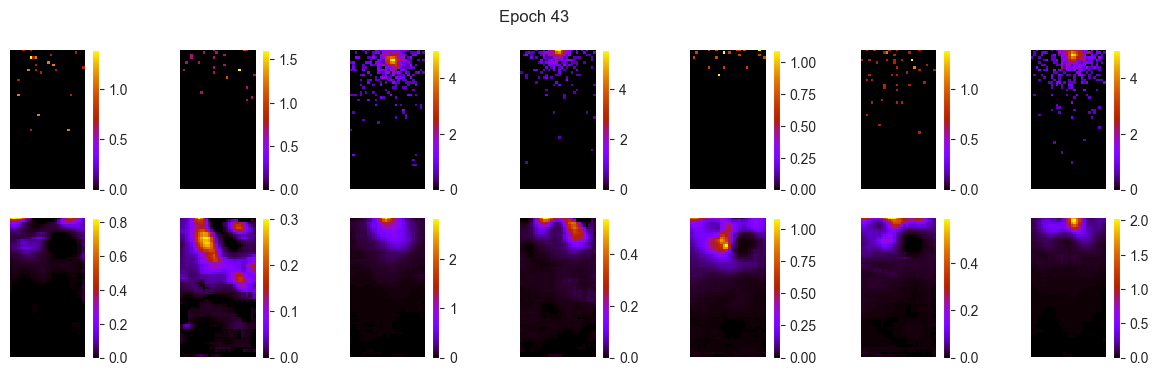

206/206 [==============================] - 1s 7ms/step
ws mean 43.90 ch1 31.04 ch2 73.89 ch3 0.70 ch4 1.02 ch5 112.82 Time for epoch 43 is 28.254154682159424 sec
8900 [Total loss: 46.03] [Recon_loss: 46.03] [KL loss: 0.00]
9000 [Total loss: 46.00] [Recon_loss: 46.00] [KL loss: 0.00]


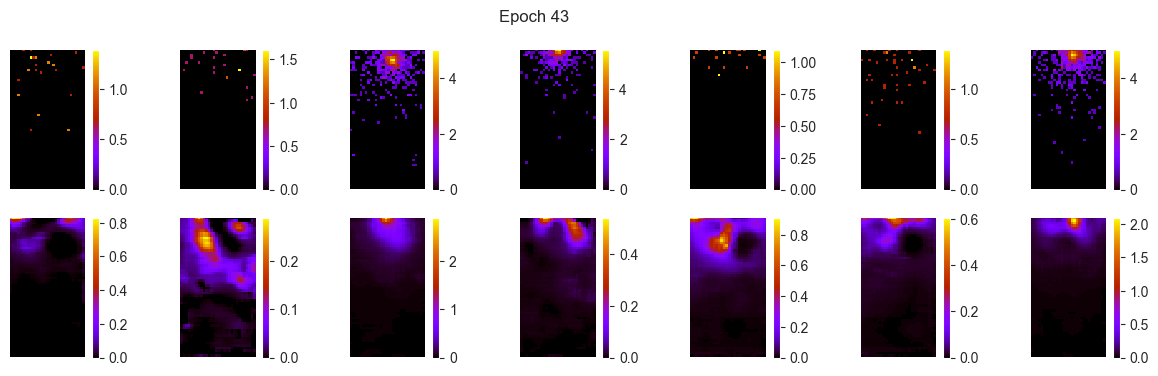

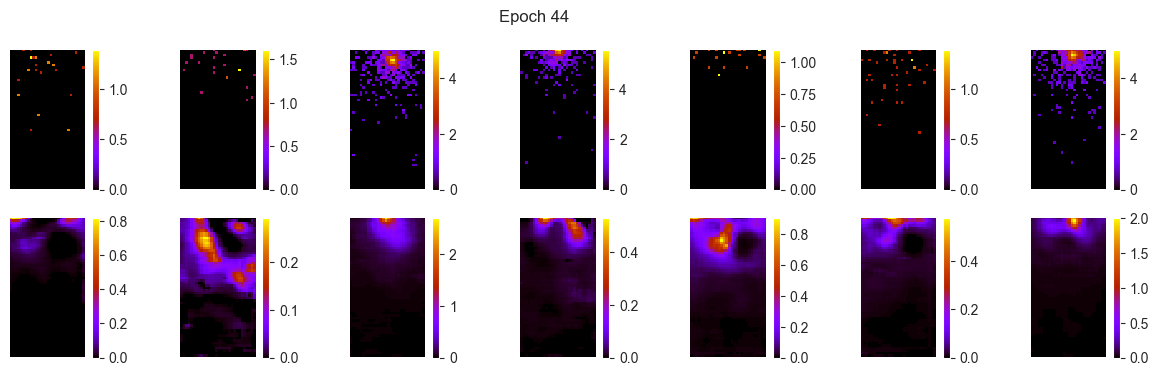

206/206 [==============================] - 1s 7ms/step
ws mean 44.21 ch1 31.22 ch2 74.64 ch3 0.61 ch4 0.87 ch5 113.73 Time for epoch 44 is 32.41928482055664 sec
9100 [Total loss: 35.58] [Recon_loss: 35.58] [KL loss: 0.00]
9200 [Total loss: 45.65] [Recon_loss: 45.65] [KL loss: 0.00]


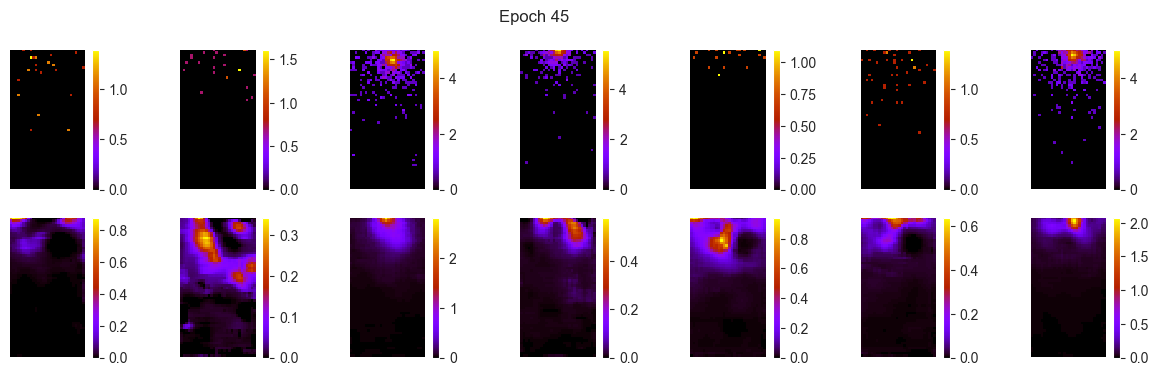

206/206 [==============================] - 1s 7ms/step
ws mean 44.76 ch1 31.66 ch2 74.73 ch3 1.17 ch4 1.45 ch5 114.77 Time for epoch 45 is 28.254738330841064 sec
9300 [Total loss: 48.21] [Recon_loss: 48.21] [KL loss: 0.00]
9400 [Total loss: 43.14] [Recon_loss: 43.14] [KL loss: 0.00]


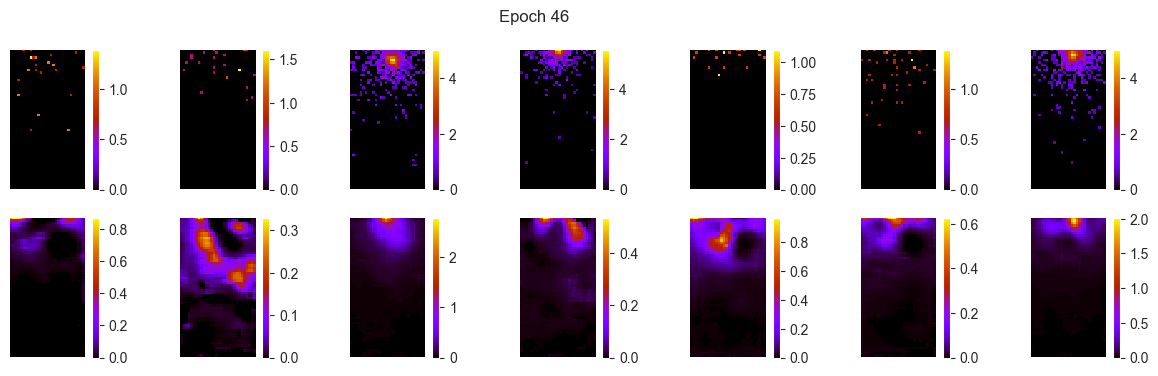

206/206 [==============================] - 1s 7ms/step
ws mean 44.47 ch1 31.19 ch2 75.00 ch3 0.81 ch4 1.14 ch5 114.20 Time for epoch 46 is 28.7145516872406 sec
9500 [Total loss: 39.50] [Recon_loss: 39.50] [KL loss: 0.00]
9600 [Total loss: 44.46] [Recon_loss: 44.46] [KL loss: 0.00]


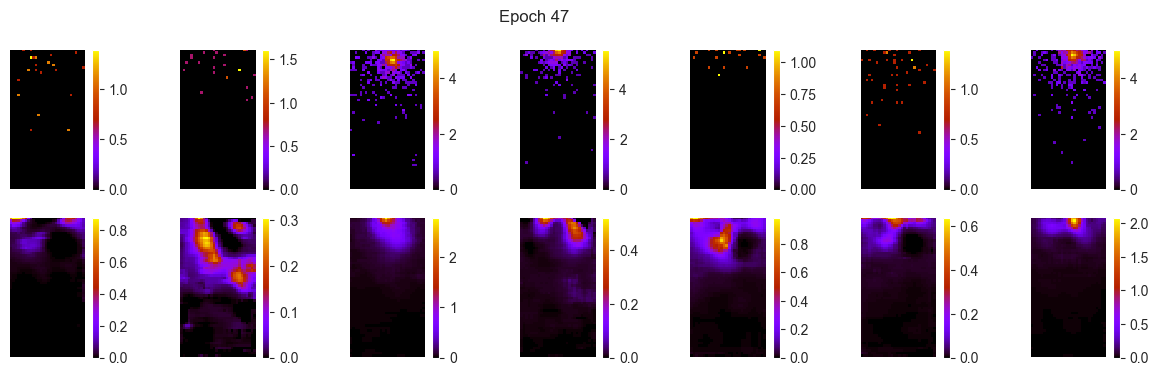

206/206 [==============================] - 1s 7ms/step
ws mean 44.63 ch1 31.48 ch2 75.06 ch3 0.83 ch4 1.09 ch5 114.71 Time for epoch 47 is 28.51626753807068 sec
9700 [Total loss: 45.04] [Recon_loss: 45.04] [KL loss: 0.00]
9800 [Total loss: 40.65] [Recon_loss: 40.65] [KL loss: 0.00]


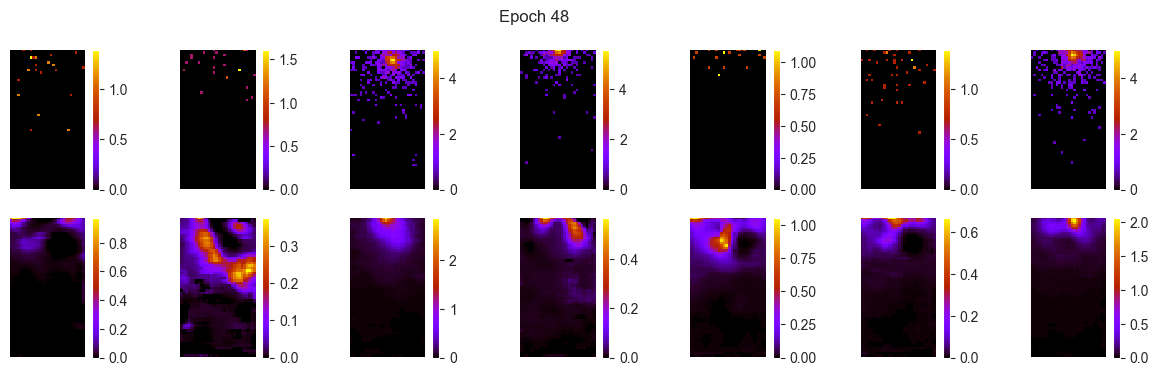

206/206 [==============================] - 1s 7ms/step
ws mean 44.68 ch1 31.41 ch2 74.51 ch3 1.46 ch4 1.65 ch5 114.39 Time for epoch 48 is 28.172434091567993 sec
9900 [Total loss: 47.84] [Recon_loss: 47.84] [KL loss: 0.00]
10000 [Total loss: 43.15] [Recon_loss: 43.15] [KL loss: 0.00]


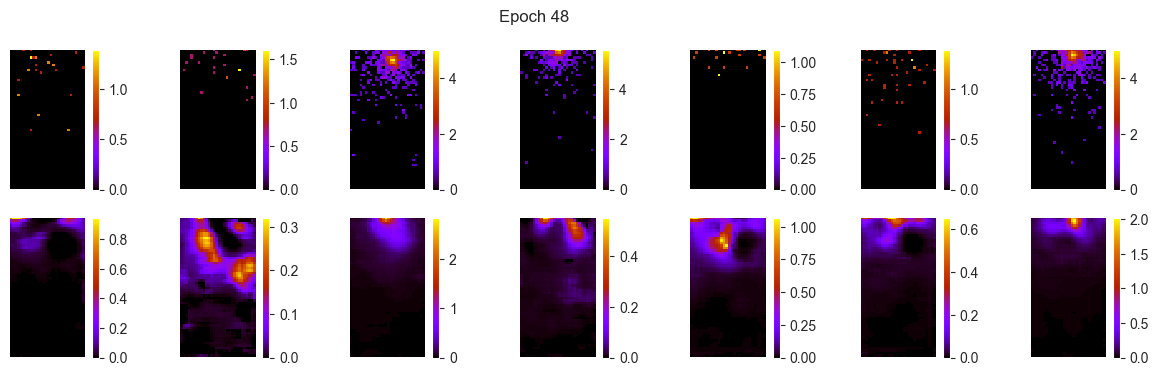

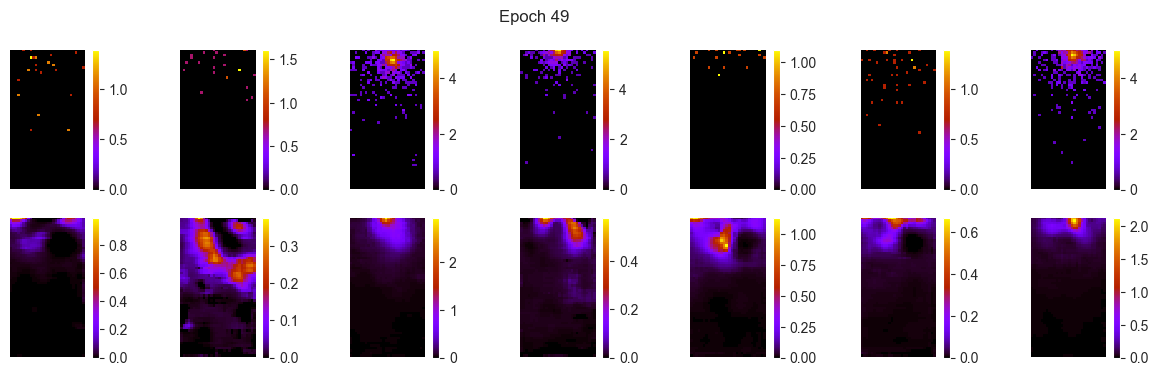

206/206 [==============================] - 1s 7ms/step
ws mean 45.16 ch1 31.79 ch2 75.03 ch3 1.55 ch4 1.75 ch5 115.68 Time for epoch 49 is 33.358285427093506 sec
10100 [Total loss: 44.82] [Recon_loss: 44.82] [KL loss: 0.00]
10200 [Total loss: 39.95] [Recon_loss: 39.95] [KL loss: 0.00]
10300 [Total loss: 47.33] [Recon_loss: 47.33] [KL loss: 0.00]


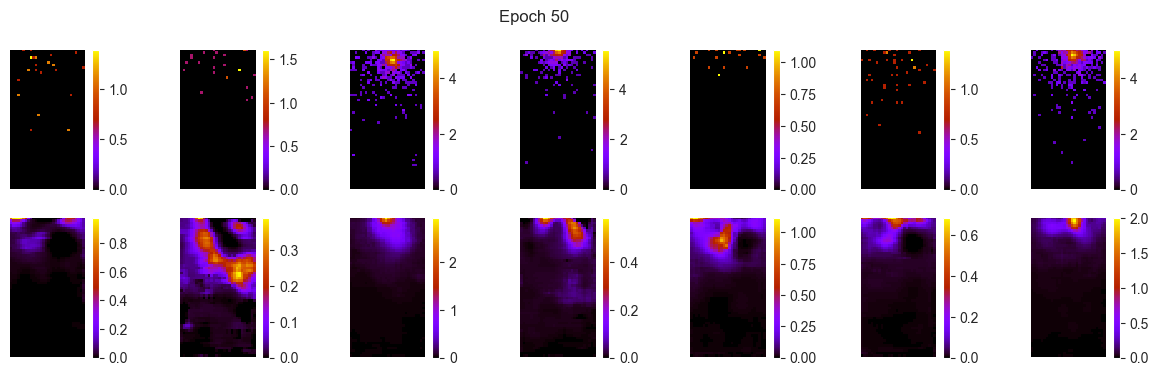

206/206 [==============================] - 1s 7ms/step
ws mean 45.15 ch1 31.62 ch2 75.32 ch3 1.74 ch4 1.93 ch5 115.16 Time for epoch 50 is 28.562893629074097 sec
10400 [Total loss: 47.72] [Recon_loss: 47.72] [KL loss: 0.00]
10500 [Total loss: 44.81] [Recon_loss: 44.81] [KL loss: 0.00]


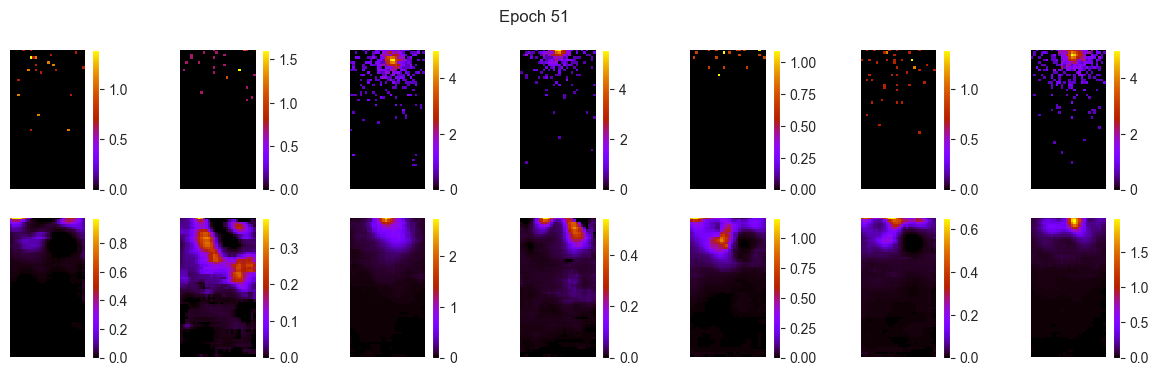

206/206 [==============================] - 1s 7ms/step
ws mean 45.38 ch1 31.71 ch2 76.26 ch3 1.40 ch4 1.62 ch5 115.88 Time for epoch 51 is 28.024018049240112 sec
10600 [Total loss: 35.37] [Recon_loss: 35.37] [KL loss: 0.00]
10700 [Total loss: 47.98] [Recon_loss: 47.98] [KL loss: 0.00]


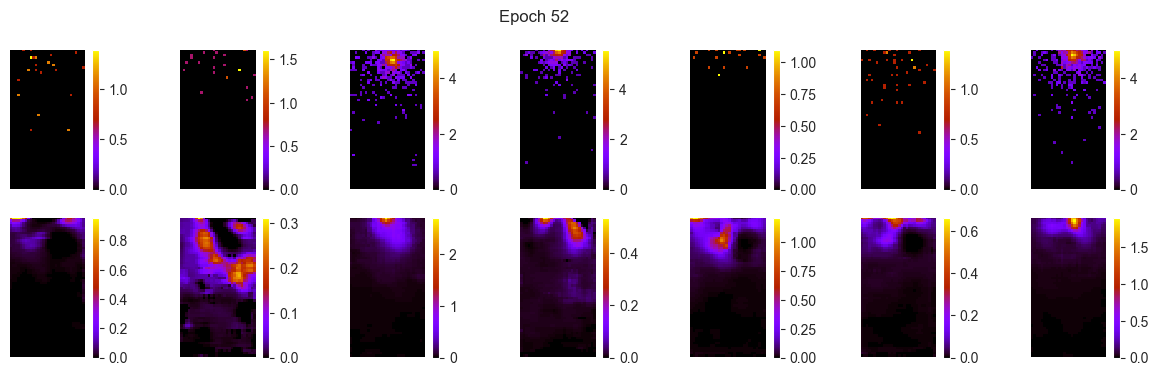

206/206 [==============================] - 1s 7ms/step
ws mean 45.65 ch1 31.86 ch2 76.76 ch3 1.32 ch4 1.54 ch5 116.77 Time for epoch 52 is 28.252241611480713 sec
10800 [Total loss: 44.83] [Recon_loss: 44.83] [KL loss: 0.00]
10900 [Total loss: 48.41] [Recon_loss: 48.41] [KL loss: 0.00]


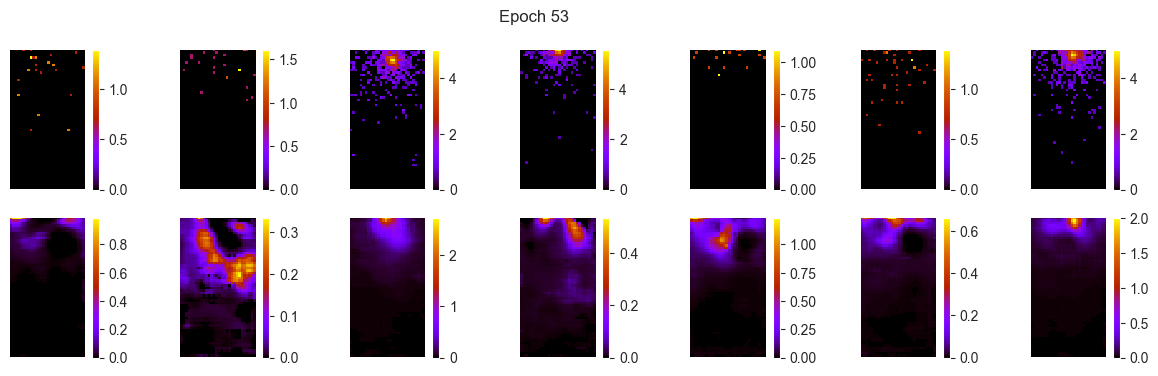

206/206 [==============================] - 1s 7ms/step
ws mean 45.10 ch1 31.53 ch2 75.73 ch3 1.33 ch4 1.62 ch5 115.30 Time for epoch 53 is 27.270663499832153 sec
11000 [Total loss: 47.37] [Recon_loss: 47.37] [KL loss: 0.00]


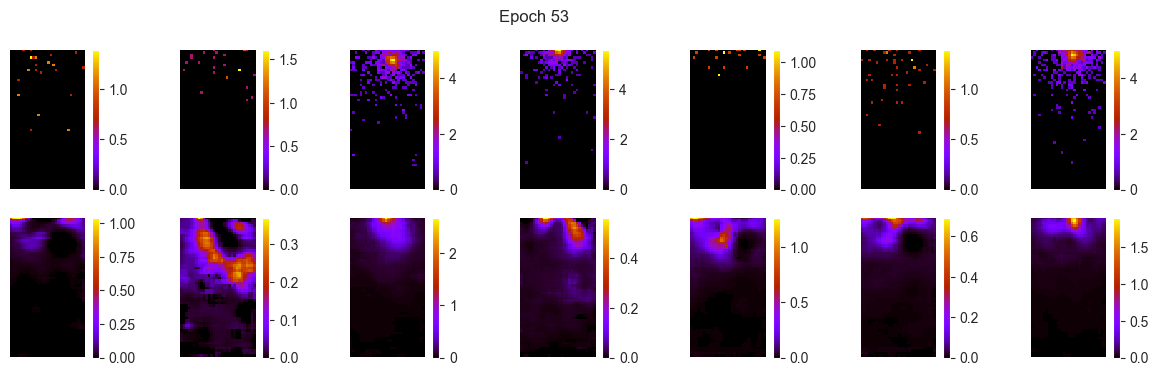

11100 [Total loss: 40.04] [Recon_loss: 40.04] [KL loss: 0.00]


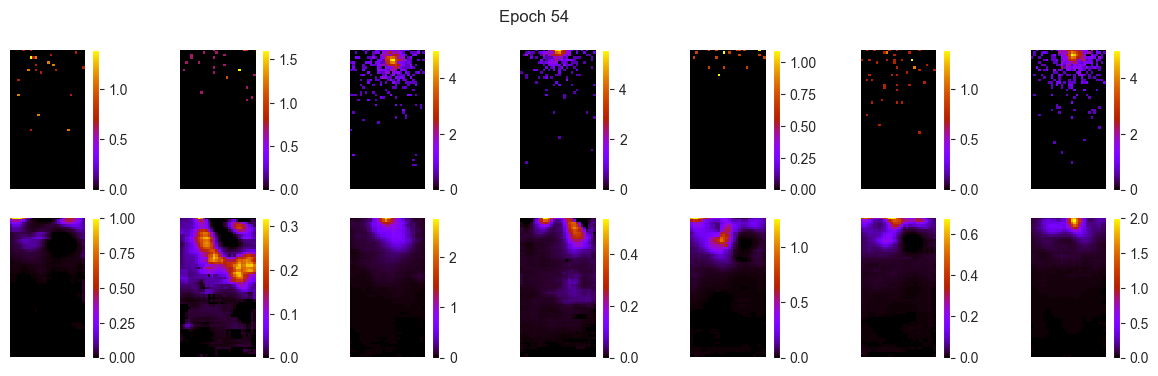

206/206 [==============================] - 1s 7ms/step
ws mean 45.70 ch1 31.83 ch2 76.83 ch3 1.42 ch4 1.66 ch5 116.76 Time for epoch 54 is 30.9077091217041 sec
11200 [Total loss: 43.53] [Recon_loss: 43.53] [KL loss: 0.00]
11300 [Total loss: 46.55] [Recon_loss: 46.55] [KL loss: 0.00]


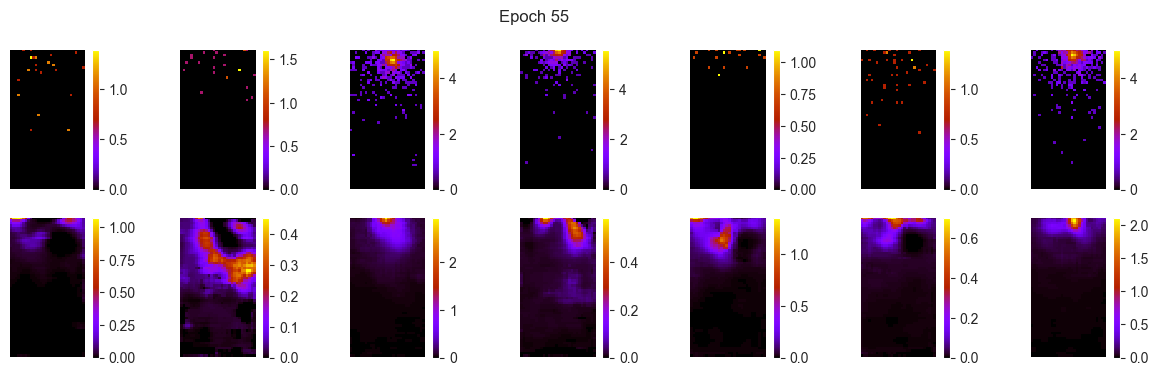

206/206 [==============================] - 1s 7ms/step
ws mean 45.67 ch1 31.86 ch2 76.00 ch3 1.87 ch4 2.20 ch5 116.40 Time for epoch 55 is 27.285016775131226 sec
11400 [Total loss: 42.08] [Recon_loss: 42.08] [KL loss: 0.00]
11500 [Total loss: 37.59] [Recon_loss: 37.59] [KL loss: 0.00]


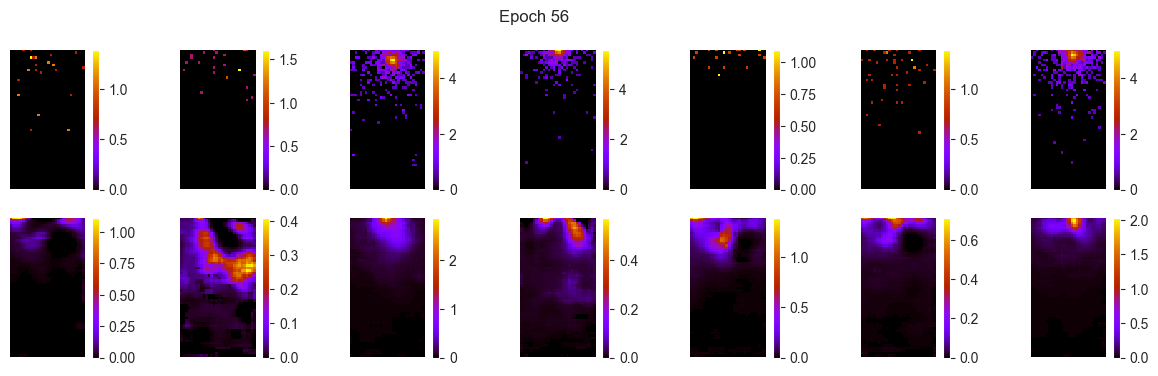

206/206 [==============================] - 1s 7ms/step
ws mean 45.39 ch1 31.73 ch2 75.82 ch3 1.48 ch4 1.92 ch5 116.02 Time for epoch 56 is 27.033337116241455 sec
11600 [Total loss: 51.54] [Recon_loss: 51.54] [KL loss: 0.00]
11700 [Total loss: 42.15] [Recon_loss: 42.15] [KL loss: 0.00]


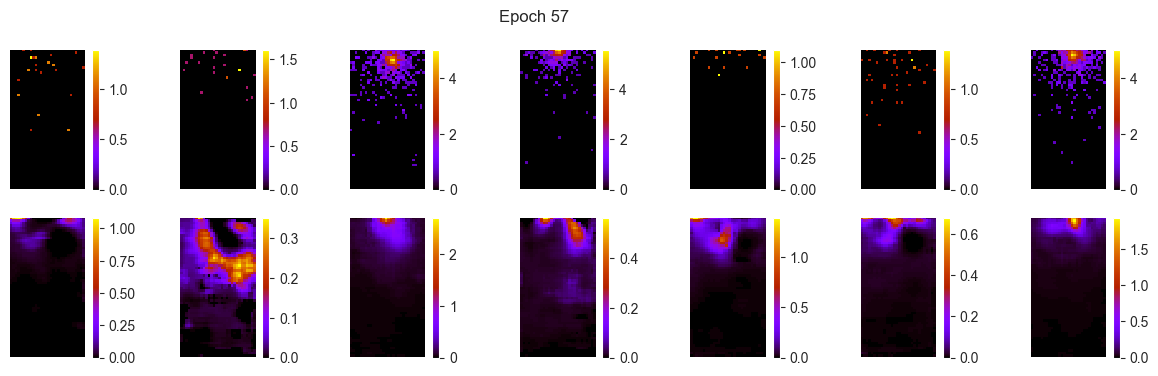

206/206 [==============================] - 1s 7ms/step
ws mean 46.16 ch1 32.22 ch2 77.48 ch3 1.37 ch4 1.71 ch5 118.03 Time for epoch 57 is 26.950732231140137 sec
11800 [Total loss: 43.41] [Recon_loss: 43.41] [KL loss: 0.00]
11900 [Total loss: 41.35] [Recon_loss: 41.35] [KL loss: 0.00]


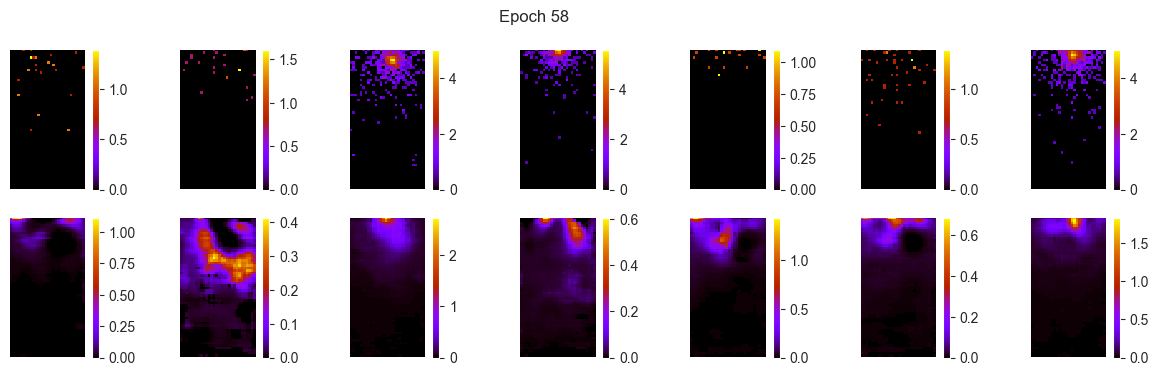

206/206 [==============================] - 1s 7ms/step
ws mean 46.21 ch1 32.17 ch2 77.57 ch3 1.53 ch4 1.78 ch5 118.01 Time for epoch 58 is 27.68512487411499 sec
12000 [Total loss: 38.13] [Recon_loss: 38.13] [KL loss: 0.00]


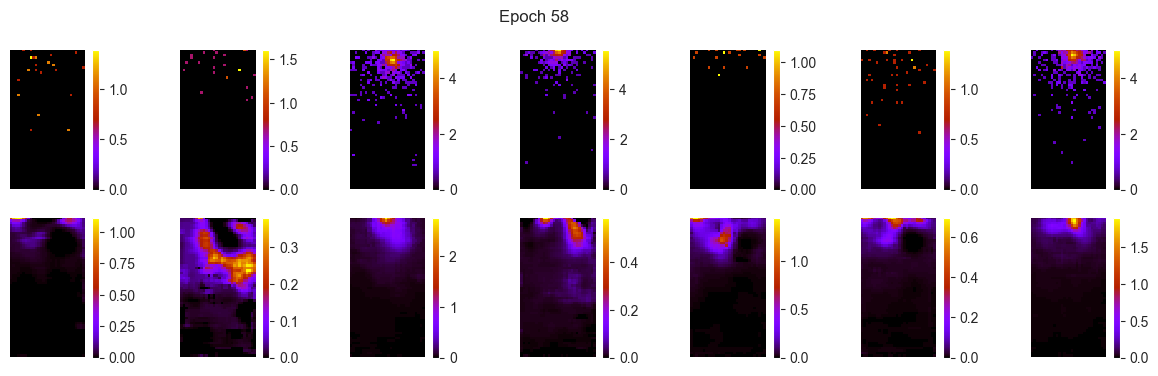

12100 [Total loss: 43.06] [Recon_loss: 43.06] [KL loss: 0.00]


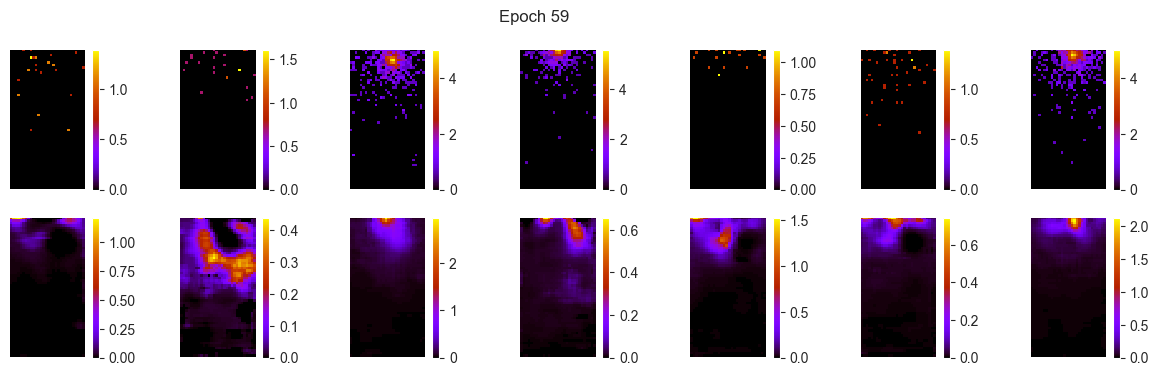

206/206 [==============================] - 1s 7ms/step
ws mean 45.55 ch1 31.79 ch2 76.10 ch3 1.48 ch4 1.89 ch5 116.48 Time for epoch 59 is 31.47507619857788 sec
12200 [Total loss: 42.75] [Recon_loss: 42.75] [KL loss: 0.00]
12300 [Total loss: 46.99] [Recon_loss: 46.99] [KL loss: 0.00]


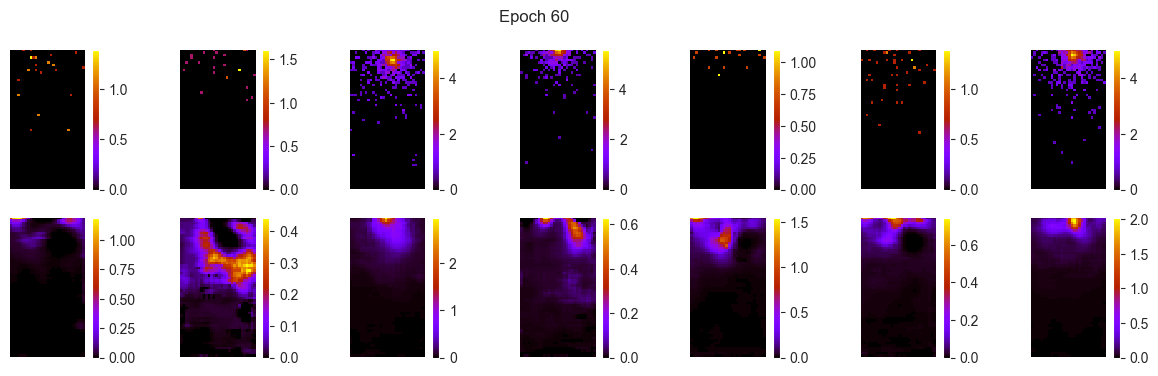

206/206 [==============================] - 1s 7ms/step
ws mean 45.30 ch1 31.45 ch2 75.86 ch3 1.58 ch4 1.98 ch5 115.64 Time for epoch 60 is 27.093189001083374 sec
12400 [Total loss: 46.61] [Recon_loss: 46.61] [KL loss: 0.00]
12500 [Total loss: 43.44] [Recon_loss: 43.44] [KL loss: 0.00]


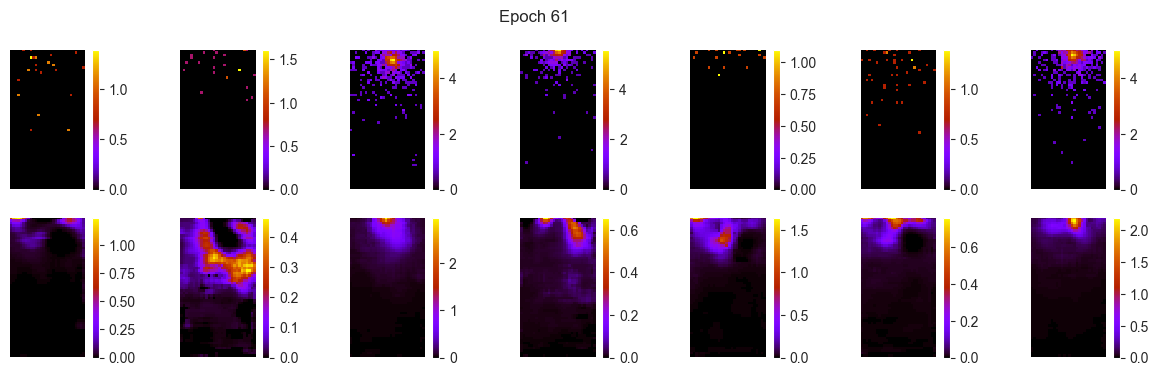

206/206 [==============================] - 1s 7ms/step
ws mean 45.40 ch1 31.75 ch2 75.59 ch3 1.61 ch4 1.98 ch5 116.08 Time for epoch 61 is 27.813371896743774 sec
12600 [Total loss: 41.62] [Recon_loss: 41.62] [KL loss: 0.00]
12700 [Total loss: 42.47] [Recon_loss: 42.47] [KL loss: 0.00]


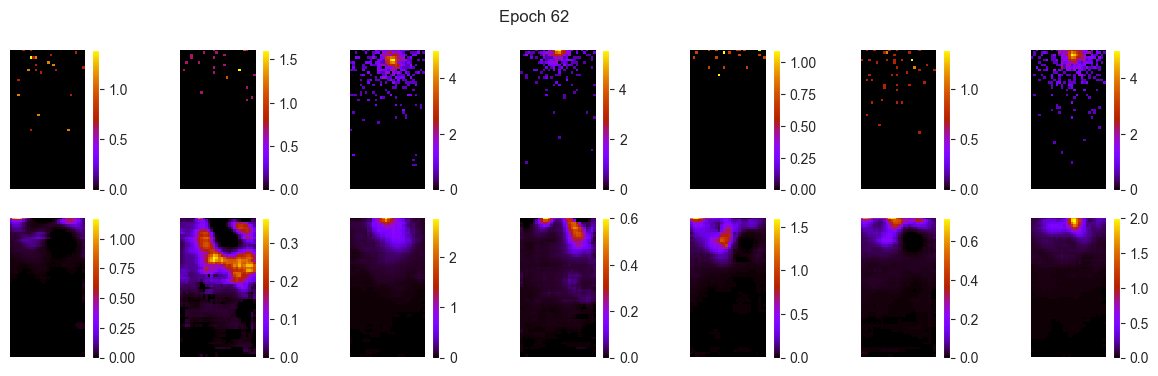

206/206 [==============================] - 1s 7ms/step
ws mean 45.30 ch1 31.28 ch2 76.57 ch3 1.06 ch4 1.39 ch5 116.20 Time for epoch 62 is 27.93338179588318 sec
12800 [Total loss: 45.19] [Recon_loss: 45.19] [KL loss: 0.00]
12900 [Total loss: 45.02] [Recon_loss: 45.02] [KL loss: 0.00]


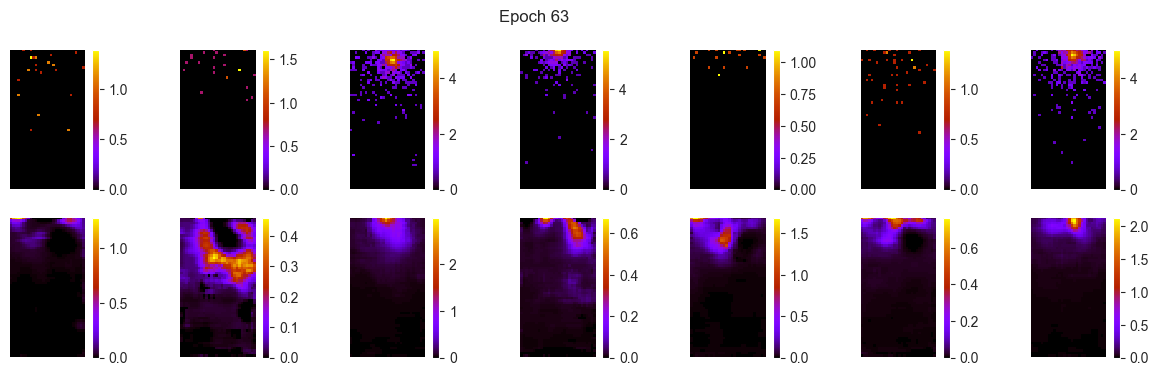

206/206 [==============================] - 1s 7ms/step
ws mean 45.41 ch1 31.29 ch2 76.04 ch3 1.48 ch4 1.93 ch5 116.33 Time for epoch 63 is 28.635796308517456 sec
13000 [Total loss: 42.14] [Recon_loss: 42.14] [KL loss: 0.00]


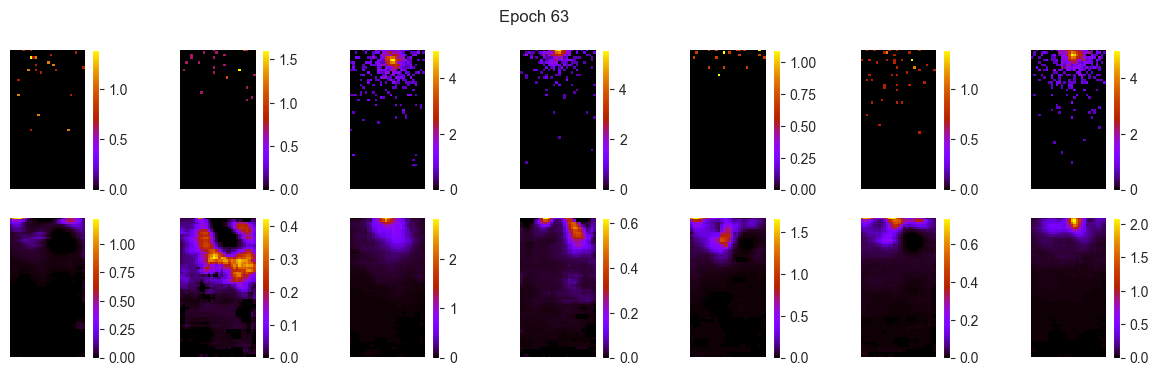

13100 [Total loss: 47.84] [Recon_loss: 47.84] [KL loss: 0.00]


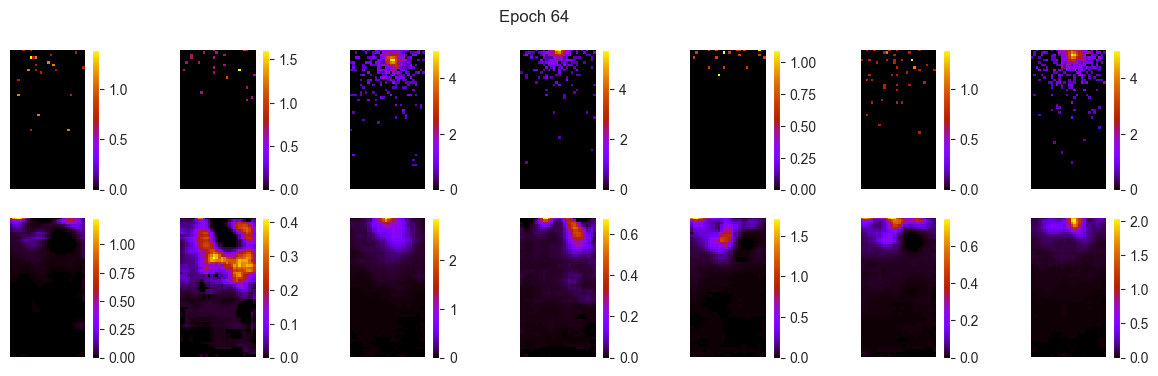

206/206 [==============================] - 1s 7ms/step
ws mean 46.12 ch1 32.11 ch2 77.30 ch3 1.39 ch4 1.75 ch5 118.05 Time for epoch 64 is 31.51650333404541 sec
13200 [Total loss: 46.53] [Recon_loss: 46.53] [KL loss: 0.00]
13300 [Total loss: 43.90] [Recon_loss: 43.90] [KL loss: 0.00]


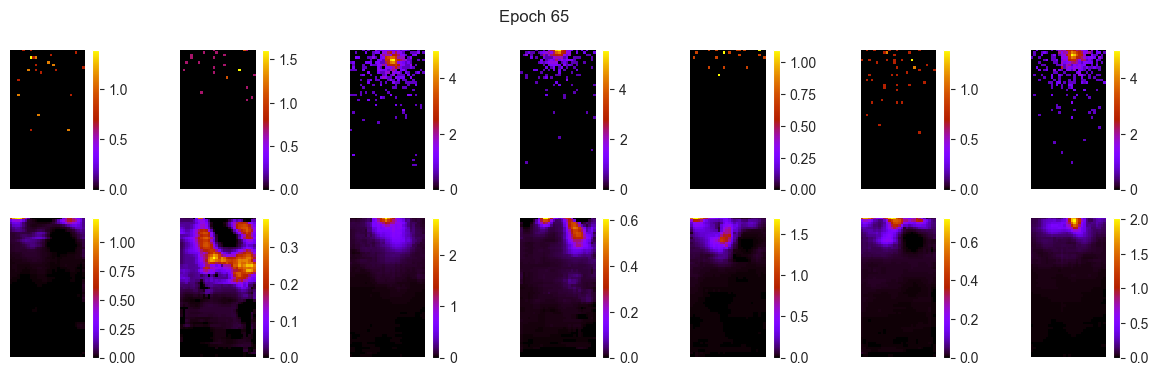

206/206 [==============================] - 1s 7ms/step
ws mean 46.13 ch1 32.12 ch2 77.82 ch3 1.02 ch4 1.31 ch5 118.36 Time for epoch 65 is 28.726551055908203 sec
13400 [Total loss: 39.46] [Recon_loss: 39.46] [KL loss: 0.00]
13500 [Total loss: 46.47] [Recon_loss: 46.47] [KL loss: 0.00]


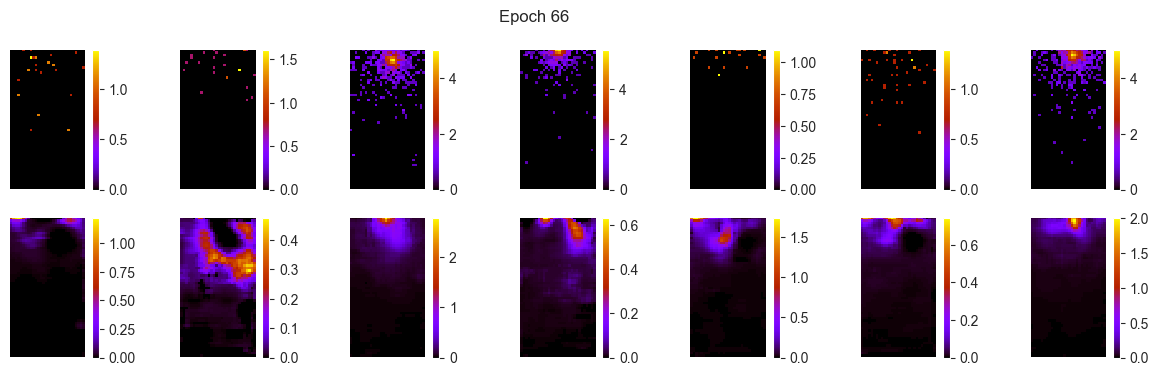

206/206 [==============================] - 1s 7ms/step
ws mean 45.82 ch1 31.71 ch2 77.32 ch3 1.07 ch4 1.43 ch5 117.55 Time for epoch 66 is 28.14658808708191 sec
13600 [Total loss: 47.86] [Recon_loss: 47.86] [KL loss: 0.00]
13700 [Total loss: 43.14] [Recon_loss: 43.14] [KL loss: 0.00]
13800 [Total loss: 47.63] [Recon_loss: 47.63] [KL loss: 0.00]


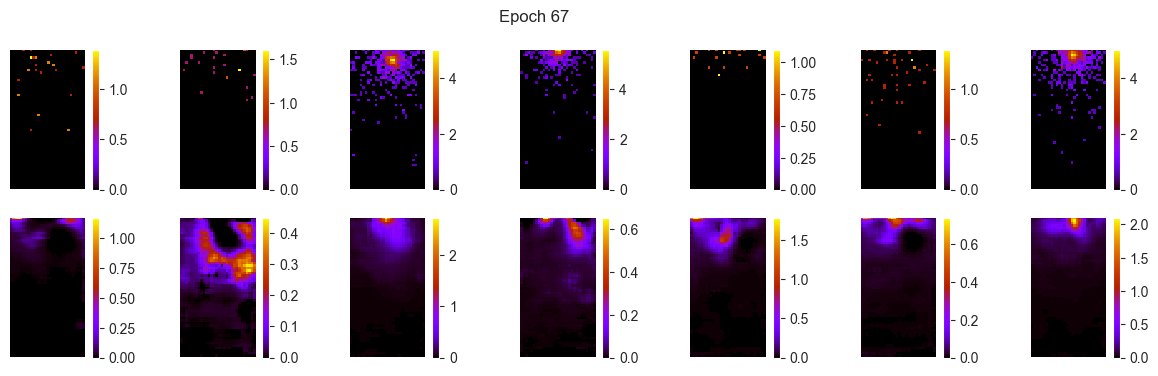

206/206 [==============================] - 1s 7ms/step
ws mean 45.62 ch1 31.70 ch2 77.10 ch3 0.86 ch4 1.20 ch5 117.22 Time for epoch 67 is 28.08329939842224 sec
13900 [Total loss: 38.46] [Recon_loss: 38.46] [KL loss: 0.00]
14000 [Total loss: 42.08] [Recon_loss: 42.08] [KL loss: 0.00]


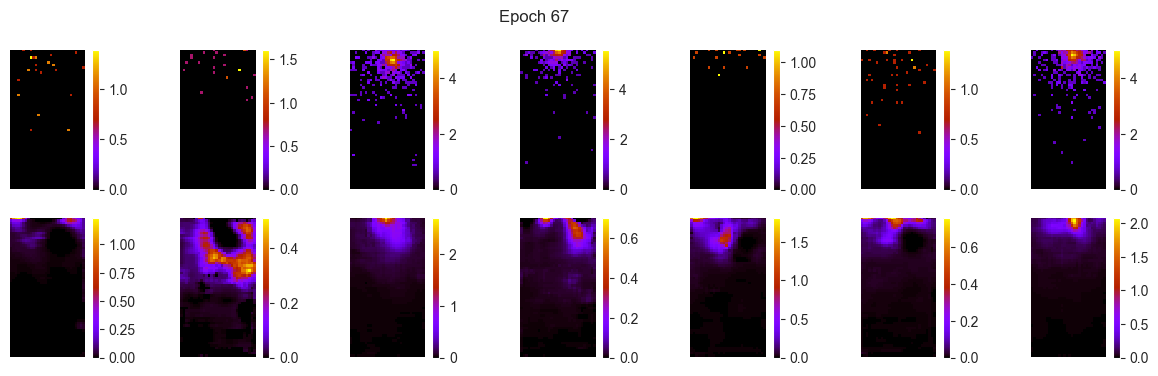

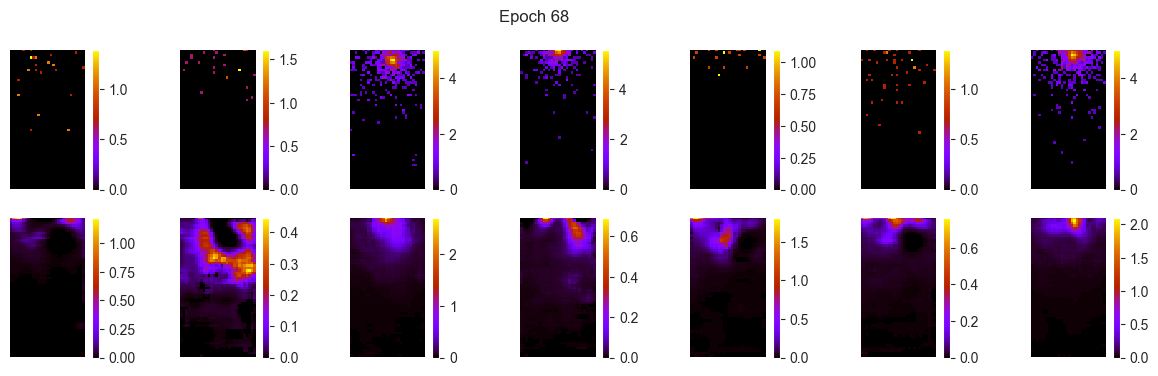

206/206 [==============================] - 1s 7ms/step
ws mean 45.64 ch1 31.66 ch2 77.20 ch3 0.88 ch4 1.14 ch5 117.33 Time for epoch 68 is 31.237147331237793 sec
14100 [Total loss: 45.87] [Recon_loss: 45.87] [KL loss: 0.00]
14200 [Total loss: 48.76] [Recon_loss: 48.76] [KL loss: 0.00]


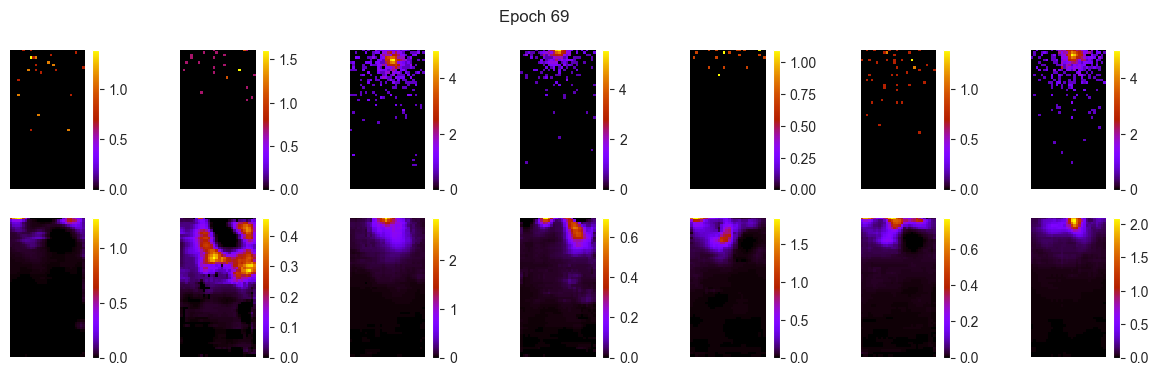

206/206 [==============================] - 1s 7ms/step
ws mean 45.12 ch1 31.43 ch2 75.88 ch3 0.96 ch4 1.41 ch5 115.92 Time for epoch 69 is 27.35895013809204 sec
14300 [Total loss: 37.95] [Recon_loss: 37.95] [KL loss: 0.00]
14400 [Total loss: 47.68] [Recon_loss: 47.68] [KL loss: 0.00]


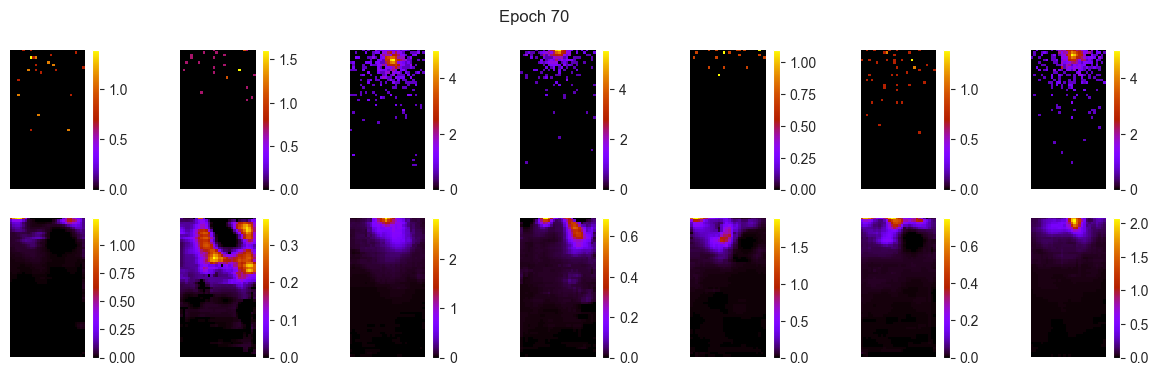

206/206 [==============================] - 1s 7ms/step
ws mean 45.58 ch1 31.69 ch2 77.20 ch3 0.72 ch4 0.93 ch5 117.34 Time for epoch 70 is 27.45255208015442 sec


In [23]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        # kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # total_loss = 0.7 * kl_loss + reconstruction_loss
        kl_loss = 0  # TODO: remove
        total_loss = reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss


history = []
history_loss = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # # Save the model every epoch
        # encoder.save_weights("../models/enc_"+NAME + "_"+ str(epoch) +".h5")
        # generator.save_weights("../models/gen_"+NAME + "_"+ str(epoch) +".h5")
        # np.savez("../models/history_"+NAME+".npz",np.array(history))
        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 4))
    fig.suptitle(f"Epoch {epoch}")
    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, interpolation='none', cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])
    plt.savefig('.././images/proton/without_regularizer/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# ### Train model
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [24]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [25]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [26]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [29]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(f'.././images/proton/without_regularizer/loss_{loss_str}_epochs_{EPOCHS}.png')

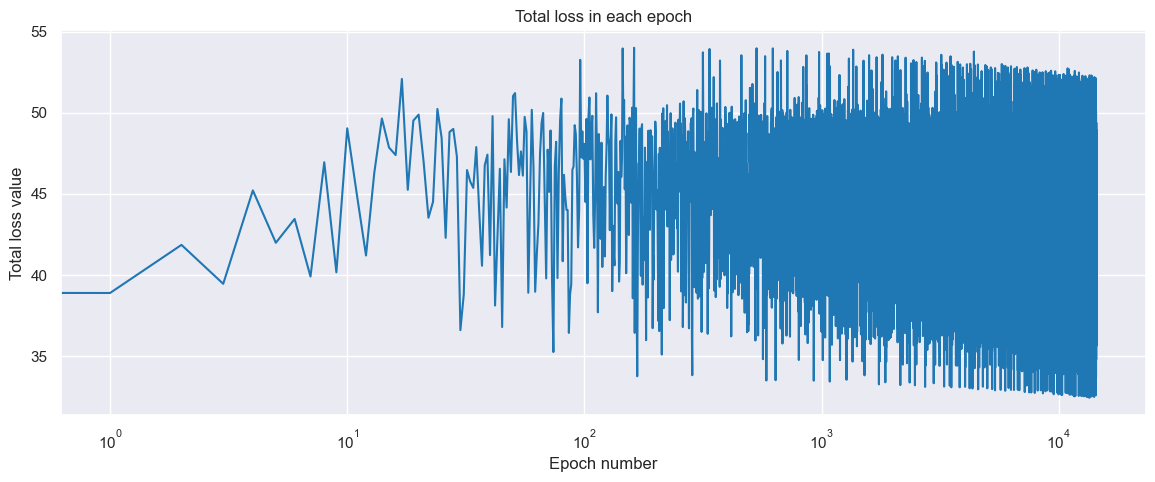

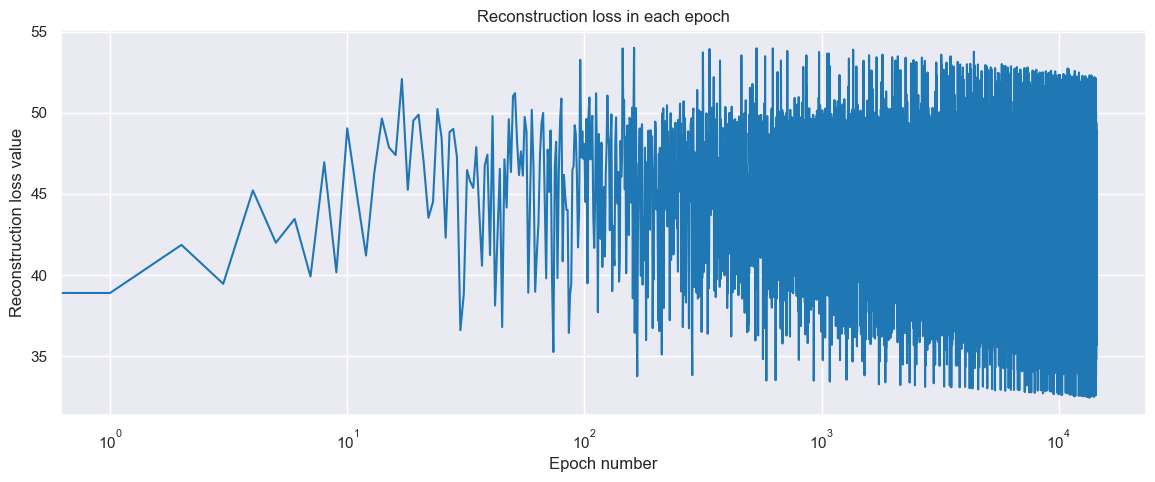

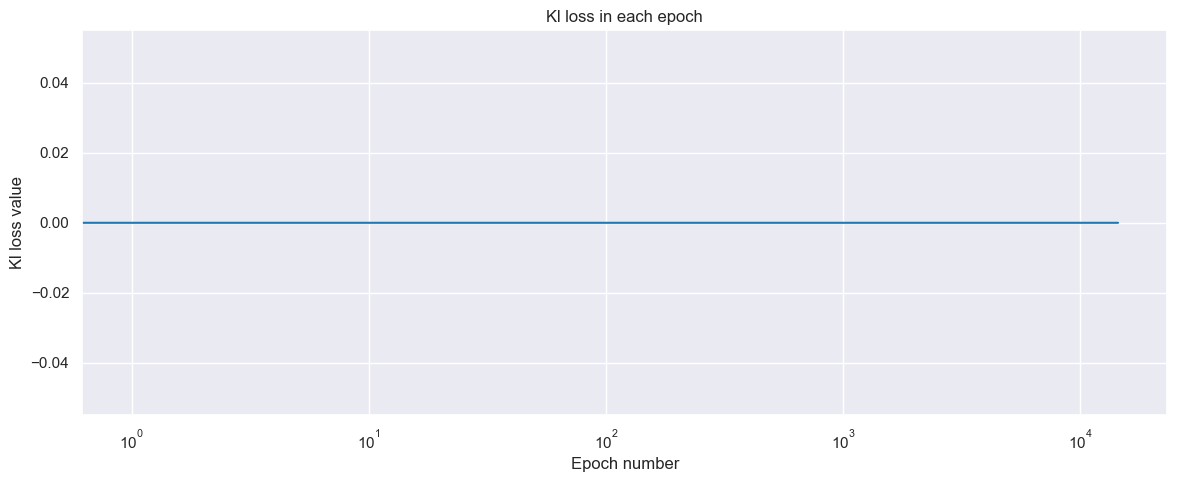

In [31]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")

In [105]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [106]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [112]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")

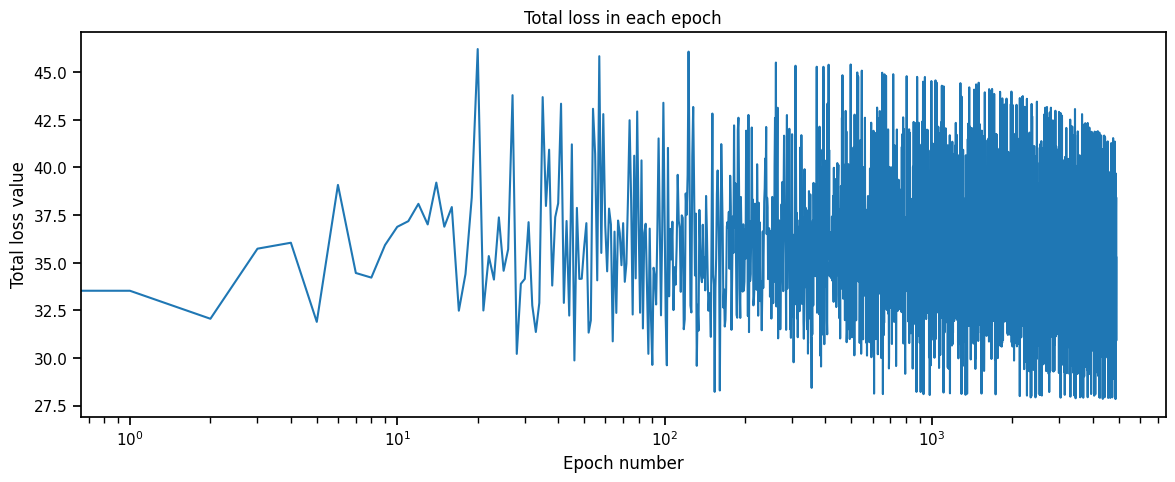

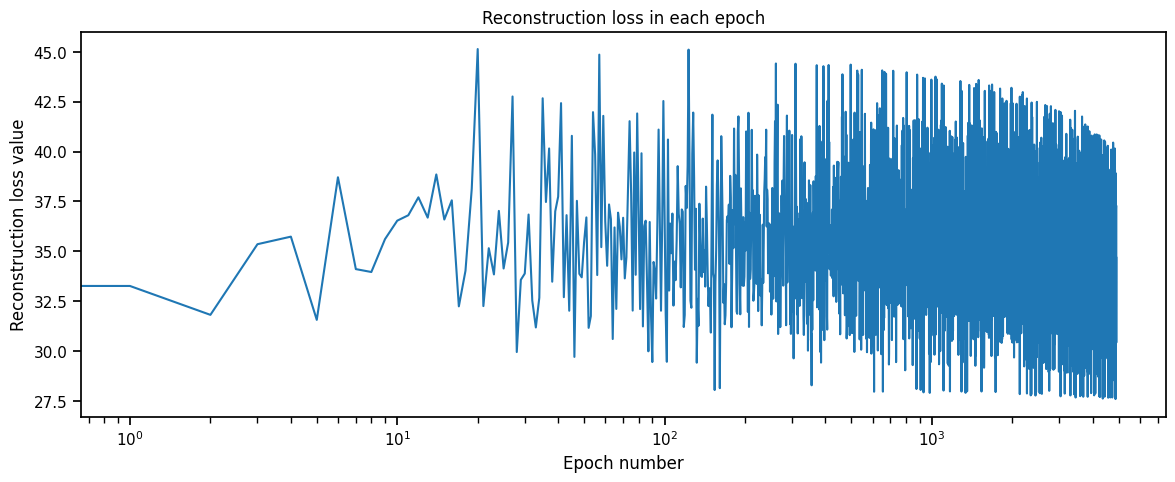

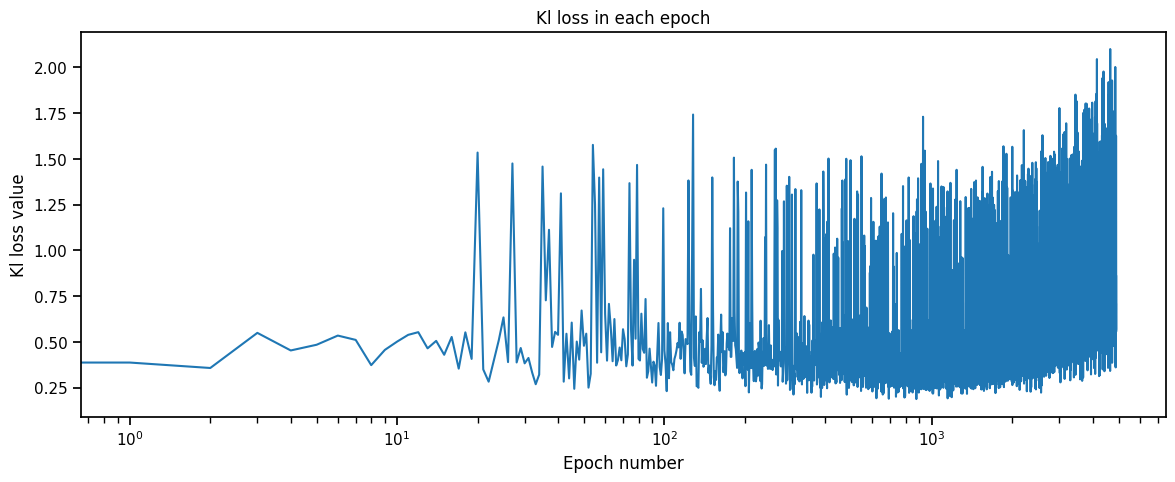

In [113]:
print_loss(total_loss[::10], "Total")
print_loss(reconstruction_loss[::10], "Reconstruction")
print_loss(kl_loss[::10], "Kl")